In [85]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [86]:
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

In [87]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [88]:
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

In [89]:
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

In [90]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
"medium")) # make size a categorical variable

In [91]:
df['id']=df['Store'].astype(str) + '-'+ df['Dept'].astype(str)

df.groupby('id').agg({'Date':'count'}).reset_index().sort_values(by='Date')

result = df.groupby('id').agg({'Date':'count'}).reset_index()
result = result[result['Date'] == 143].sort_values(by='Date')
result

id  Date
0       1-1   143
2162  35-42   143
2163  35-44   143
2165  35-46   143
2168   35-5   143
...     ...   ...
1069  21-82   143
1070  21-83   143
1071  21-85   143
1073   21-9   143
3328   9-96   143

[2660 rows x 2 columns]

In [92]:
df = df[df['id'].isin(result['id'])]
# reduce running time by forecasting only top 7 stores
top_7_stores = df.groupby(['Store']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(7)
df = df[df['Store'].isin(top_7_stores['Store'])]

In [93]:
df

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
10244       2     1 2010-02-05      35034.06          0    A  medium   
10245       2     1 2010-02-12      60483.70          1    A  medium   
10246       2     1 2010-02-19      58221.52          0    A  medium   
10247       2     1 2010-02-26      25962.32          0    A  medium   
10248       2     1 2010-03-05      27372.05          0    A  medium   
...       ...   ...        ...           ...        ...  ...     ...   
266938     27    98 2012-09-28       9696.08          0    A   large   
266939     27    98 2012-10-05       9936.23          0    A   large   
266940     27    98 2012-10-12      11374.41          0    A   large   
266941     27    98 2012-10-19      10955.07          0    A   large   
266942     27    98 2012-10-26      13222.70          0    A   large   

        Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
10244         40.19       2.572       0.00       0.00       0.00       0.00   
10245         38.49       2.548       0.00       0.00       0.00       0.00   
10246         39.69       2.514       0.00       0.00       0.00       0.00   
10247         46.10       2.561       0.00       0.00       0.00       0.00   
10248         47.17       2.625       0.00       0.00       0.00       0.00   
...             ...         ...        ...        ...        ...        ...   
266938        64.92       4.158   26306.03      39.82      55.24   11296.93   
266939        64.50       4.151   16670.04       0.00      40.02    5385.32   
266940        55.40       4.186    2177.62       0.00       7.22     863.01   
266941        56.53       4.153    2639.32       0.00       4.77     575.48   
266942        58.99       4.071    7756.75     206.45     100.00     731.23   

        MarkDown5         CPI  Unemployment     id  
10244        0.00  210.752605         8.324    2-1  
10245        0.00  210.897994         8.324    2-1  
10246        0.00  210.945160         8.324    2-1  
10247        0.00  210.975957         8.324    2-1  
10248        0.00  211.006754         8.324    2-1  
...           ...         ...           ...    ...  
266938   12954.12  142.765750         8.239  27-98  
266939    6733.38  142.851683         8.000  27-98  
266940    7931.82  142.937617         8.000  27-98  
266941    3147.23  142.863363         8.000  27-98  
266942    2174.84  142.762411         8.000  27-98  

[67353 rows x 17 columns]

In [94]:
df.head

<bound method NDFrame.head of         Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
10244       2     1 2010-02-05      35034.06          0    A  medium   
10245       2     1 2010-02-12      60483.70          1    A  medium   
10246       2     1 2010-02-19      58221.52          0    A  medium   
10247       2     1 2010-02-26      25962.32          0    A  medium   
10248       2     1 2010-03-05      27372.05          0    A  medium   
...       ...   ...        ...           ...        ...  ...     ...   
266938     27    98 2012-09-28       9696.08          0    A   large   
266939     27    98 2012-10-05       9936.23          0    A   large   
266940     27    98 2012-10-12      11374.41          0    A   large   
266941     27    98 2012-10-19      10955.07          0    A   large   
266942     27    98 2012-10-26      13222.70          0    A   large   

        Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
10244         40.19       

In [95]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

forecasts = []

for id_value in df['id'].unique():
    df_id = df[df['id'] == id_value]
    df_id.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

    model = Prophet()

    model.fit(df_id[:-16])
    
    future_dates = model.make_future_dataframe(periods=16, freq=FREQ)

    forecast = model.predict(future_dates)
    forecasts.append(forecast)


full_forecast = pd.concat(forecasts, ignore_index=True)

full_forecast

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_32792/2287179773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing


/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_32792/2287179773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_32792/2287179773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processin

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0     2010-02-05  32174.813116  30165.862176  55862.168193  32174.813116   
1     2010-02-12  32155.899952  38628.072410  62528.111701  32155.899952   
2     2010-02-19  32136.986789  37290.603378  62645.224376  32136.986789   
3     2010-02-26  32118.073625  26944.612479  51091.024299  32118.073625   
4     2010-03-05  32099.160461  14174.374771  38150.723348  32099.160461   
...          ...           ...           ...           ...           ...   
67348 2012-09-28  10846.515169   7648.946515  11159.868701  10846.514922   
67349 2012-10-05  10835.763471   7980.932323  11488.985412  10835.763193   
67350 2012-10-12  10825.011774   8812.560245  12137.818715  10825.011464   
67351 2012-10-19  10814.260077   9313.263929  12707.684861  10814.259732   
67352 2012-10-26  10803.508380   9329.152249  12893.910566  10803.507996   

        trend_upper  additive_terms  additive_terms_lower  \
0      32174.813116    11311.227589          11311.227589   
1      32155.899952    19298.070570          19298.070570   
2      32136.986789    17546.485406          17546.485406   
3      32118.073625     6823.155726           6823.155726   
4      32099.160461    -5812.282716          -5812.282716   
...             ...             ...                   ...   
67348  10846.515382    -1395.310148          -1395.310148   
67349  10835.763710    -1081.904233          -1081.904233   
67350  10825.012044     -316.844971           -316.844971   
67351  10814.260379      262.508590            262.508590   
67352  10803.508719      335.082079            335.082079   

       additive_terms_upper        yearly  yearly_lower  yearly_upper  \
0              11311.227589  11311.227589  11311.227589  11311.227589   
1              19298.070570  19298.070570  19298.070570  19298.070570   
2              17546.485406  17546.485406  17546.485406  17546.485406   
3               6823.155726   6823.155726   6823.155726   6823.155726   
4              -5812.282716  -5812.282716  -5812.282716  -5812.282716   
...                     ...           ...           ...           ...   
67348          -1395.310148  -1395.310148  -1395.310148  -1395.310148   
67349          -1081.904233  -1081.904233  -1081.904233  -1081.904233   
67350           -316.844971   -316.844971   -316.844971   -316.844971   
67351            262.508590    262.508590    262.508590    262.508590   
67352            335.082079    335.082079    335.082079    335.082079   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
67348                   0.0                         0.0   
67349                   0.0                         0.0   
67350                   0.0                         0.0   
67351                   0.0                         0.0   
67352                   0.0                         0.0   

       multiplicative_terms_upper          yhat  
0                             0.0  43486.040705  
1                             0.0  51453.970522  
2                             0.0  49683.472195  
3                             0.0  38941.229351  
4                             0.0  26286.877746  
...                           ...           ...  
67348                         0.0   9451.205020  
67349                         0.0   9753.859238  
67350                         0.0  10508.166803  
67351                         0.0  11076.768667  
67352                         0.0  11138.590459  

[67353 rows x 16 columns]

In [96]:
df=df.reset_index(drop=True)

In [97]:
full_forecast['id']=df['id']

In [98]:
df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

merged_df = pd.merge(df, full_forecast, on=['ds','id'], how='inner')

residuos = merged_df['y'] - merged_df['yhat']

merged_df['residuos'] = residuos

print(merged_df[['ds', 'yhat', 'residuos']])

              ds          yhat      residuos
0     2010-02-05  43486.040705  -8451.980705
1     2010-02-12  51453.970522   9029.729478
2     2010-02-19  49683.472195   8538.047805
3     2010-02-26  38941.229351 -12978.909351
4     2010-03-05  26286.877746   1085.172254
...          ...           ...           ...
67348 2012-09-28   9451.205020    244.874980
67349 2012-10-05   9753.859238    182.370762
67350 2012-10-12  10508.166803    866.243197
67351 2012-10-19  11076.768667   -121.698667
67352 2012-10-26  11138.590459   2084.109541

[67353 rows x 3 columns]


In [99]:
merged_df

Store  Dept         ds         y  IsHoliday Type    Size  Temperature  \
0          2     1 2010-02-05  35034.06          0    A  medium        40.19   
1          2     1 2010-02-12  60483.70          1    A  medium        38.49   
2          2     1 2010-02-19  58221.52          0    A  medium        39.69   
3          2     1 2010-02-26  25962.32          0    A  medium        46.10   
4          2     1 2010-03-05  27372.05          0    A  medium        47.17   
...      ...   ...        ...       ...        ...  ...     ...          ...   
67348     27    98 2012-09-28   9696.08          0    A   large        64.92   
67349     27    98 2012-10-05   9936.23          0    A   large        64.50   
67350     27    98 2012-10-12  11374.41          0    A   large        55.40   
67351     27    98 2012-10-19  10955.07          0    A   large        56.53   
67352     27    98 2012-10-26  13222.70          0    A   large        58.99   

       Fuel_Price  MarkDown1  ...  additive_terms_lower  additive_terms_upper  \
0           2.572       0.00  ...          11311.227589          11311.227589   
1           2.548       0.00  ...          19298.070570          19298.070570   
2           2.514       0.00  ...          17546.485406          17546.485406   
3           2.561       0.00  ...           6823.155726           6823.155726   
4           2.625       0.00  ...          -5812.282716          -5812.282716   
...           ...        ...  ...                   ...                   ...   
67348       4.158   26306.03  ...          -1395.310148          -1395.310148   
67349       4.151   16670.04  ...          -1081.904233          -1081.904233   
67350       4.186    2177.62  ...           -316.844971           -316.844971   
67351       4.153    2639.32  ...            262.508590            262.508590   
67352       4.071    7756.75  ...            335.082079            335.082079   

             yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0      11311.227589  11311.227589  11311.227589                   0.0   
1      19298.070570  19298.070570  19298.070570                   0.0   
2      17546.485406  17546.485406  17546.485406                   0.0   
3       6823.155726   6823.155726   6823.155726                   0.0   
4      -5812.282716  -5812.282716  -5812.282716                   0.0   
...             ...           ...           ...                   ...   
67348  -1395.310148  -1395.310148  -1395.310148                   0.0   
67349  -1081.904233  -1081.904233  -1081.904233                   0.0   
67350   -316.844971   -316.844971   -316.844971                   0.0   
67351    262.508590    262.508590    262.508590                   0.0   
67352    335.082079    335.082079    335.082079                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  \
0                            0.0                         0.0  43486.040705   
1                            0.0                         0.0  51453.970522   
2                            0.0                         0.0  49683.472195   
3                            0.0                         0.0  38941.229351   
4                            0.0                         0.0  26286.877746   
...                          ...                         ...           ...   
67348                        0.0                         0.0   9451.205020   
67349                        0.0                         0.0   9753.859238   
67350                        0.0                         0.0  10508.166803   
67351                        0.0                         0.0  11076.768667   
67352                        0.0                         0.0  11138.590459   

           residuos  
0      -8451.980705  
1       9029.729478  
2       8538.047805  
3     -12978.909351  
4       1085.172254  
...             ...  
67348    244.874980  
67349    182.370762  
67350    866.243197  
67351   -121.698667  
67352   2084.1095

In [100]:
merged_df_res=pd.get_dummies(merged_df,columns=['Size','Type'])
# Identificar colunas geradas pelo get_dummies
dummies_columns = [col for col in merged_df_res.columns if col.startswith('Size_') or col.startswith('Type_')]

# Converter colunas booleanas para inteiros (0 e 1)
merged_df_res[dummies_columns] = merged_df_res[dummies_columns].astype(int)

# Verifique novamente os tipos de dados para garantir que a conversão foi bem-sucedida
print(merged_df_res[dummies_columns].dtypes)

merged_df_res

Size_large     int64
Size_medium    int64
Type_A         int64
Type_B         int64
dtype: object


Store  Dept         ds         y  IsHoliday  Temperature  Fuel_Price  \
0          2     1 2010-02-05  35034.06          0        40.19       2.572   
1          2     1 2010-02-12  60483.70          1        38.49       2.548   
2          2     1 2010-02-19  58221.52          0        39.69       2.514   
3          2     1 2010-02-26  25962.32          0        46.10       2.561   
4          2     1 2010-03-05  27372.05          0        47.17       2.625   
...      ...   ...        ...       ...        ...          ...         ...   
67348     27    98 2012-09-28   9696.08          0        64.92       4.158   
67349     27    98 2012-10-05   9936.23          0        64.50       4.151   
67350     27    98 2012-10-12  11374.41          0        55.40       4.186   
67351     27    98 2012-10-19  10955.07          0        56.53       4.153   
67352     27    98 2012-10-26  13222.70          0        58.99       4.071   

       MarkDown1  MarkDown2  MarkDown3  ...  yearly_upper  \
0           0.00       0.00       0.00  ...  11311.227589   
1           0.00       0.00       0.00  ...  19298.070570   
2           0.00       0.00       0.00  ...  17546.485406   
3           0.00       0.00       0.00  ...   6823.155726   
4           0.00       0.00       0.00  ...  -5812.282716   
...          ...        ...        ...  ...           ...   
67348   26306.03      39.82      55.24  ...  -1395.310148   
67349   16670.04       0.00      40.02  ...  -1081.904233   
67350    2177.62       0.00       7.22  ...   -316.844971   
67351    2639.32       0.00       4.77  ...    262.508590   
67352    7756.75     206.45     100.00  ...    335.082079   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
67348                   0.0                         0.0   
67349                   0.0                         0.0   
67350                   0.0                         0.0   
67351                   0.0                         0.0   
67352                   0.0                         0.0   

       multiplicative_terms_upper          yhat      residuos  Size_large  \
0                             0.0  43486.040705  -8451.980705           0   
1                             0.0  51453.970522   9029.729478           0   
2                             0.0  49683.472195   8538.047805           0   
3                             0.0  38941.229351 -12978.909351           0   
4                             0.0  26286.877746   1085.172254           0   
...                           ...           ...           ...         ...   
67348                         0.0   9451.205020    244.874980           1   
67349                         0.0   9753.859238    182.370762           1   
67350                         0.0  10508.166803    866.243197           1   
67351                         0.0  11076.768667   -121.698667           1   
67352                         0.0  11138.590459   2084.109541           1   

       Size_medium  Type_A  Type_B  
0                1       1       0  
1                1       1       0  
2                1       1       0  
3                1       1       0  
4                1       1       0  
...            ...     ...     ...  
67348            0       1       0  
67349            0       1       0  
67350            0       1       0  
67351            0       1       0  
67352            0       1       0  

[67353 rows x 35 columns]

In [101]:
df_train=merged_df_res.groupby('id').apply(lambda x: x.iloc[:-16]).reset_index(drop=True)
df_test=merged_df_res.groupby('id').apply(lambda x: x.iloc[-16:]).reset_index(drop=True)

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_32792/2015827512.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train=merged_df_res.groupby('id').apply(lambda x: x.iloc[:-16]).reset_index(drop=True)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_32792/2015827512.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test=merged_df_res.groupby('id').apply(lambda x: x.iloc[-16:]

In [102]:
df_train

Store  Dept         ds         y  IsHoliday  Temperature  Fuel_Price  \
0         10     1 2010-02-05  40212.84          0        54.34       2.962   
1         10     1 2010-02-12  67699.32          1        49.96       2.828   
2         10     1 2010-02-19  49748.33          0        58.22       2.915   
3         10     1 2010-02-26  33601.22          0        52.77       2.825   
4         10     1 2010-03-05  36572.44          0        55.92       2.877   
...      ...   ...        ...       ...        ...          ...         ...   
59812      4    98 2012-06-08  13461.71          0        78.11       3.433   
59813      4    98 2012-06-15  14501.34          0        80.94       3.372   
59814      4    98 2012-06-22  15855.00          0        81.63       3.329   
59815      4    98 2012-06-29  13874.74          0        84.23       3.257   
59816      4    98 2012-07-06  16379.57          0        80.37       3.187   

       MarkDown1  MarkDown2  MarkDown3  ...  yearly_upper  \
0           0.00       0.00       0.00  ...   7235.718837   
1           0.00       0.00       0.00  ...  11165.281076   
2           0.00       0.00       0.00  ...   8400.692161   
3           0.00       0.00       0.00  ...   -222.041560   
4           0.00       0.00       0.00  ... -10596.475677   
...          ...        ...        ...  ...           ...   
59812    7429.46     249.80       7.86  ...  -2418.406697   
59813   16063.84      84.00       0.22  ...  -2286.661253   
59814    6619.20     351.22       3.48  ...  -1263.048681   
59815    3756.11     211.60       0.00  ...   -579.519661   
59816    9789.03      90.00     157.62  ...   -938.344703   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
59812                   0.0                         0.0   
59813                   0.0                         0.0   
59814                   0.0                         0.0   
59815                   0.0                         0.0   
59816                   0.0                         0.0   

       multiplicative_terms_upper          yhat      residuos  Size_large  \
0                             0.0  50538.462513 -10325.622513           0   
1                             0.0  54434.560836  13264.759164           0   
2                             0.0  51636.508006  -1888.178006           0   
3                             0.0  42980.310371  -9379.090371           0   
4                             0.0  32572.412338   4000.027662           0   
...                           ...           ...           ...         ...   
59812                         0.0  13464.143614     -2.433614           1   
59813                         0.0  13609.613044    891.726956           1   
59814                         0.0  14646.949601   1208.050399           1   
59815                         0.0  15344.202608  -1469.462608           1   
59816                         0.0  14999.101551   1380.468449           1   

       Size_medium  Type_A  Type_B  
0                1       0       1  
1                1       0       1  
2                1       0       1  
3                1       0       1  
4                1       0       1  
...            ...     ...     ...  
59812            0       1       0  
59813            0       1       0  
59814            0       1       0  
59815            0       1       0  
59816            0       1       0  

[59817 rows x 35 columns]

In [103]:
df_test

Store  Dept         ds         y  IsHoliday  Temperature  Fuel_Price  \
0        10     1 2012-07-13  26000.97          0        89.80       3.723   
1        10     1 2012-07-20  27065.94          0        84.45       3.589   
2        10     1 2012-07-27  26303.34          0        83.98       3.769   
3        10     1 2012-08-03  26390.26          0        84.76       3.595   
4        10     1 2012-08-10  26320.29          0        90.78       3.811   
...     ...   ...        ...       ...        ...          ...         ...   
7531      4    98 2012-09-28  16293.63          0        71.74       3.666   
7532      4    98 2012-10-05  16475.72          0        63.07       3.620   
7533      4    98 2012-10-12  17300.73          0        57.11       3.603   
7534      4    98 2012-10-19  17641.28          0        64.46       3.610   
7535      4    98 2012-10-26  19176.14          0        63.64       3.514   

      MarkDown1  MarkDown2  MarkDown3  ...  yearly_upper  \
0       7069.25       5.00       0.32  ... -15475.654731   
1       6596.80      -1.60      44.60  ... -14745.671881   
2       9511.34       0.00       8.87  ... -15095.242104   
3      37194.44       0.00      53.40  ... -15816.215149   
4      15282.47       0.00      58.80  ... -15672.882572   
...         ...        ...        ...  ...           ...   
7531    5333.92       5.73       2.94  ...  -1488.935031   
7532    5918.34       0.00     126.57  ...   -466.063660   
7533    4975.39       0.00      61.17  ...    736.196891   
7534    6313.84       0.00      15.05  ...   1158.848800   
7535    1763.13      88.76      66.76  ...    859.338721   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
7531                   0.0                         0.0   
7532                   0.0                         0.0   
7533                   0.0                         0.0   
7534                   0.0                         0.0   
7535                   0.0                         0.0   

      multiplicative_terms_upper          yhat     residuos  Size_large  \
0                            0.0  23893.739745  2107.230255           0   
1                            0.0  24593.897196  2472.042804           0   
2                            0.0  24214.501573  2088.838427           0   
3                            0.0  23463.703129  2926.556871           0   
4                            0.0  23577.210307  2743.079693           0   
...                          ...           ...          ...         ...   
7531                         0.0  14613.199054  1680.430946           1   
7532                         0.0  15649.794411   825.925589           1   
7533                         0.0  16865.778948   434.951052           1   
7534                         0.0  17302.154843   339.125157           1   
7535                         0.0  17016.368749  2159.771251           1   

      Size_medium  Type_A  Type_B  
0               1       0       1  
1               1       0       1  
2               1       0       1  
3               1       0       1  
4               1       0       1  
...           ...     ...     ...  
7531            0       1       0  
7532            0       1       0  
7533            0       1       0  
7534            0       1       0  
7535            0       1       0  

[7536 rows x 35 columns]

In [143]:
df_test.columns

Index(['Store', 'Dept', 'ds', 'y', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'id', 'trend', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'residuos', 'Size_large',
       'Size_medium', 'Type_A', 'Type_B'],
      dtype='object')

In [104]:
y_train=df_train['residuos']
X_train=df_train.drop(columns=['residuos'])

y_test=df_test['residuos']
X_test=df_test.drop(columns=['residuos'])

In [105]:
X_train

Store  Dept         ds         y  IsHoliday  Temperature  Fuel_Price  \
0         10     1 2010-02-05  40212.84          0        54.34       2.962   
1         10     1 2010-02-12  67699.32          1        49.96       2.828   
2         10     1 2010-02-19  49748.33          0        58.22       2.915   
3         10     1 2010-02-26  33601.22          0        52.77       2.825   
4         10     1 2010-03-05  36572.44          0        55.92       2.877   
...      ...   ...        ...       ...        ...          ...         ...   
59812      4    98 2012-06-08  13461.71          0        78.11       3.433   
59813      4    98 2012-06-15  14501.34          0        80.94       3.372   
59814      4    98 2012-06-22  15855.00          0        81.63       3.329   
59815      4    98 2012-06-29  13874.74          0        84.23       3.257   
59816      4    98 2012-07-06  16379.57          0        80.37       3.187   

       MarkDown1  MarkDown2  MarkDown3  ...  yearly_lower  yearly_upper  \
0           0.00       0.00       0.00  ...   7235.718837   7235.718837   
1           0.00       0.00       0.00  ...  11165.281076  11165.281076   
2           0.00       0.00       0.00  ...   8400.692161   8400.692161   
3           0.00       0.00       0.00  ...   -222.041560   -222.041560   
4           0.00       0.00       0.00  ... -10596.475677 -10596.475677   
...          ...        ...        ...  ...           ...           ...   
59812    7429.46     249.80       7.86  ...  -2418.406697  -2418.406697   
59813   16063.84      84.00       0.22  ...  -2286.661253  -2286.661253   
59814    6619.20     351.22       3.48  ...  -1263.048681  -1263.048681   
59815    3756.11     211.60       0.00  ...   -579.519661   -579.519661   
59816    9789.03      90.00     157.62  ...   -938.344703   -938.344703   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
59812                   0.0                         0.0   
59813                   0.0                         0.0   
59814                   0.0                         0.0   
59815                   0.0                         0.0   
59816                   0.0                         0.0   

      multiplicative_terms_upper          yhat  Size_large  Size_medium  \
0                            0.0  50538.462513           0            1   
1                            0.0  54434.560836           0            1   
2                            0.0  51636.508006           0            1   
3                            0.0  42980.310371           0            1   
4                            0.0  32572.412338           0            1   
...                          ...           ...         ...          ...   
59812                        0.0  13464.143614           1            0   
59813                        0.0  13609.613044           1            0   
59814                        0.0  14646.949601           1            0   
59815                        0.0  15344.202608           1            0   
59816                        0.0  14999.101551           1            0   

       Type_A  Type_B  
0           0       1  
1           0       1  
2           0       1  
3           0       1  
4           0       1  
...       ...     ...  
59812       1       0  
59813       1       0  
59814       1       0  
59815       1       0  
59816       1       0  

[59817 rows x 34 columns]

In [106]:
X_test

Store  Dept         ds         y  IsHoliday  Temperature  Fuel_Price  \
0        10     1 2012-07-13  26000.97          0        89.80       3.723   
1        10     1 2012-07-20  27065.94          0        84.45       3.589   
2        10     1 2012-07-27  26303.34          0        83.98       3.769   
3        10     1 2012-08-03  26390.26          0        84.76       3.595   
4        10     1 2012-08-10  26320.29          0        90.78       3.811   
...     ...   ...        ...       ...        ...          ...         ...   
7531      4    98 2012-09-28  16293.63          0        71.74       3.666   
7532      4    98 2012-10-05  16475.72          0        63.07       3.620   
7533      4    98 2012-10-12  17300.73          0        57.11       3.603   
7534      4    98 2012-10-19  17641.28          0        64.46       3.610   
7535      4    98 2012-10-26  19176.14          0        63.64       3.514   

      MarkDown1  MarkDown2  MarkDown3  ...  yearly_lower  yearly_upper  \
0       7069.25       5.00       0.32  ... -15475.654731 -15475.654731   
1       6596.80      -1.60      44.60  ... -14745.671881 -14745.671881   
2       9511.34       0.00       8.87  ... -15095.242104 -15095.242104   
3      37194.44       0.00      53.40  ... -15816.215149 -15816.215149   
4      15282.47       0.00      58.80  ... -15672.882572 -15672.882572   
...         ...        ...        ...  ...           ...           ...   
7531    5333.92       5.73       2.94  ...  -1488.935031  -1488.935031   
7532    5918.34       0.00     126.57  ...   -466.063660   -466.063660   
7533    4975.39       0.00      61.17  ...    736.196891    736.196891   
7534    6313.84       0.00      15.05  ...   1158.848800   1158.848800   
7535    1763.13      88.76      66.76  ...    859.338721    859.338721   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
7531                   0.0                         0.0   
7532                   0.0                         0.0   
7533                   0.0                         0.0   
7534                   0.0                         0.0   
7535                   0.0                         0.0   

     multiplicative_terms_upper          yhat  Size_large  Size_medium  \
0                           0.0  23893.739745           0            1   
1                           0.0  24593.897196           0            1   
2                           0.0  24214.501573           0            1   
3                           0.0  23463.703129           0            1   
4                           0.0  23577.210307           0            1   
...                         ...           ...         ...          ...   
7531                        0.0  14613.199054           1            0   
7532                        0.0  15649.794411           1            0   
7533                        0.0  16865.778948           1            0   
7534                        0.0  17302.154843           1            0   
7535                        0.0  17016.368749           1            0   

      Type_A  Type_B  
0          0       1  
1          0       1  
2          0       1  
3          0       1  
4          0       1  
...      ...     ...  
7531       1       0  
7532       1       0  
7533       1       0  
7534       1       0  
7535       1       0  

[7536 rows x 34 columns]

In [107]:
y_train

0       -10325.622513
1        13264.759164
2        -1888.178006
3        -9379.090371
4         4000.027662
             ...     
59812       -2.433614
59813      891.726956
59814     1208.050399
59815    -1469.462608
59816     1380.468449
Name: residuos, Length: 59817, dtype: float64

In [108]:
y_test

0       2107.230255
1       2472.042804
2       2088.838427
3       2926.556871
4       2743.079693
           ...     
7531    1680.430946
7532     825.925589
7533     434.951052
7534     339.125157
7535    2159.771251
Name: residuos, Length: 7536, dtype: float64

In [109]:
X_test=X_test[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',"IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','Store',
               'Dept','Size_large','Size_medium','Type_A','Type_B']]

X_train=X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',"IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','Store',
               'Dept','Size_large','Size_medium','Type_A','Type_B']]

In [110]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

model = CatBoostRegressor()

param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.001],
    'depth': [4, 6, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=10)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START depth=4, iterations=100, learning_rate=0.01................
0:	learn: 6558.5125779	total: 2.83ms	remaining: 280ms
1:	learn: 6556.5578008	total: 4.72ms	remaining: 231ms
2:	learn: 6554.8787355	total: 6.2ms	remaining: 200ms
3:	learn: 6552.9618599	total: 7.69ms	remaining: 185ms
4:	learn: 6551.4135827	total: 9.57ms	remaining: 182ms
5:	learn: 6549.4975114	total: 11.4ms	remaining: 179ms
6:	learn: 6547.7697033	total: 13.1ms	remaining: 174ms
7:	learn: 6545.9150479	total: 14.9ms	remaining: 172ms
8:	learn: 6544.4600664	total: 16.7ms	remaining: 169ms
9:	learn: 6542.9482281	total: 18.3ms	remaining: 165ms
10:	learn: 6541.1368736	total: 20.1ms	remaining: 162ms
11:	learn: 6539.4833367	total: 21.7ms	remaining: 159ms
12:	learn: 6537.7127280	total: 23.5ms	remaining: 158ms
13:	learn: 6535.9567296	total: 25.1ms	remaining: 154ms
14:	learn: 6534.5429297	total: 27ms	remaining: 153ms
15:	learn: 6533.1332447	total: 29.1ms	remainin

In [111]:
from sklearn.metrics import mean_squared_error
best_model = grid_search.best_estimator_
y_pred_catboost = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_catboost, squared=False)
print("RMSE on residuals test set:", rmse)

RMSE on residuals test set: 5225.022181312657


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [112]:
len(y_pred_catboost)

7536

In [113]:
forecast_final_catboost= df_test['yhat']+y_pred_catboost

In [114]:
print("RMSE on final forecast test set:", mean_squared_error(df_test['y'], forecast_final_catboost, squared=False))

RMSE on final forecast test set: 5225.022181312657


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


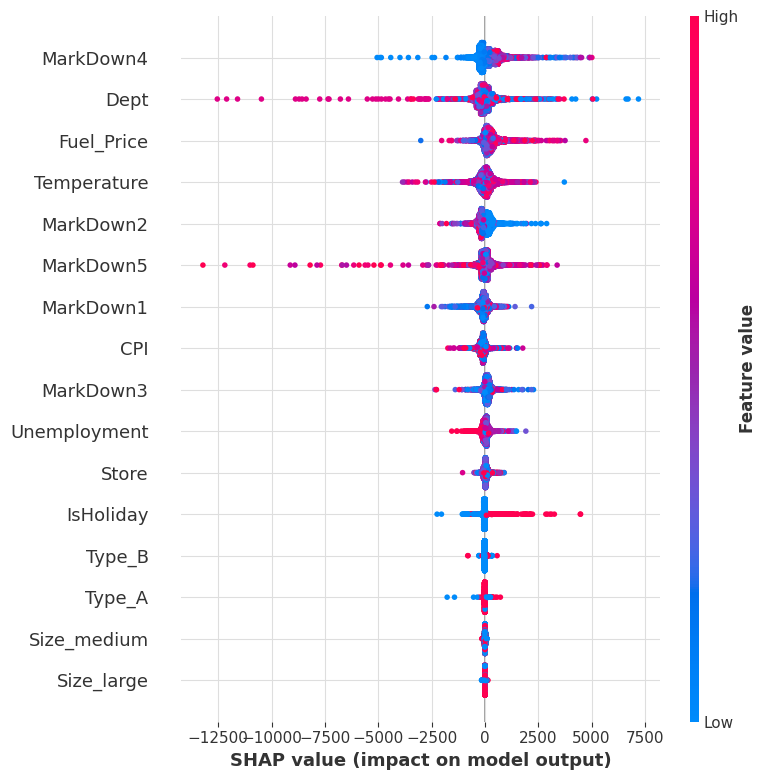

In [115]:
import pandas as pd
from catboost import CatBoostRegressor
import shap


explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)



In [116]:
X_test_id=df_test.drop(columns=['residuos'])
X_test_id=X_test_id[X_test_id['id']=='2-1']
y_id=X_test_id['yhat']
X_test_id=X_test_id[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',"IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','Store',
               'Dept','Size_large','Size_medium','Type_A','Type_B']]
X_test_id

Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  MarkDown1  \
3248        80.17       3.256  221.561678         6.565          0    8354.65   
3249        83.23       3.311  221.570112         6.565          0    6961.58   
3250        86.37       3.407  221.578546         6.565          0    6999.14   
3251        90.22       3.417  221.586980         6.565          0   27650.68   
3252        88.55       3.494  221.595414         6.565          0    5554.54   
3253        84.79       3.571  221.675146         6.565          0    4774.16   
3254        76.91       3.620  221.808352         6.565          0    4759.70   
3255        82.64       3.638  221.941558         6.565          0   17500.26   
3256        87.65       3.730  222.074763         6.565          1   10658.86   
3257        75.88       3.717  222.217440         6.565          0    8325.93   
3258        71.09       3.721  222.416936         6.565          0    6707.94   
3259        79.45       3.666  222.616433         6.565          0    7106.05   
3260        70.27       3.617  222.815930         6.170          0    6037.76   
3261        60.97       3.601  223.015426         6.170          0    2145.50   
3262        68.08       3.594  223.059808         6.170          0    4461.89   
3263        69.79       3.506  223.078337         6.170          0    6152.59   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5  Store  Dept  Size_large  \
3248     342.25      20.53    5674.44    5012.22      2     1           0   
3249     241.20      24.97    3401.36    2453.42      2     1           0   
3250     197.72       2.53    6319.33    5007.01      2     1           0   
3251     164.58      43.02   21801.90    6652.98      2     1           0   
3252     142.30      13.43    4187.43    5286.19      2     1           0   
3253     330.78      10.53    4253.28    4927.26      2     1           0   
3254     211.38       6.62    2972.88    5102.26      2     1           0   
3255      73.22      21.38   12878.62    4756.50      2     1           0   
3256     149.28      60.97    2920.90    3275.57      2     1           0   
3257       0.00      37.32    1808.69    9314.55      2     1           0   
3258       3.82      15.55    1001.42    7607.94      2     1           0   
3259       1.91       1.65    1549.10    3946.03      2     1           0   
3260       0.00      10.04    3027.37    3853.40      2     1           0   
3261       0.00      33.31     586.83   10421.01      2     1           0   
3262       0.00       1.14    1579.67    2642.29      2     1           0   
3263     129.77     200.00     272.29    2924.15      2     1           0   

      Size_medium  Type_A  Type_B  
3248            1       1       0  
3249            1       1       0  
3250            1       1       0  
3251            1       1       0  
3252            1       1       0  
3253            1       1       0  
3254            1       1       0  
3255            1       1       0  
3256            1       1       0  
3257            1       1       0  
3258            1       1       0  
3259            1       1       0  
3260            1       1       0  
3261            1       1       0  
3262            1       1       0  
3263            1       1       0

In [117]:
y_id

3248    21592.019272
3249    21139.372517
3250    19974.042897
3251    19275.177925
3252    19856.557272
3253    20963.050442
3254    21322.307349
3255    21049.981703
3256    21577.487558
3257    23454.004696
3258    25177.016172
3259    25260.860354
3260    25187.214176
3261    28731.163792
3262    37140.196813
3263    45541.108452
Name: yhat, dtype: float64

In [118]:
y_pred_catboost_id=best_model.predict(X_test_id)

In [119]:
forecast_final_catboost_id= y_id+y_pred_catboost_id

print("RMSE on final forecast test set for id='2-1':", mean_squared_error(df_test['y'], forecast_final_catboost, squared=False))

RMSE on final forecast test set for id='2-1': 5225.022181312657


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [120]:
shap_values = explainer.shap_values(X_test_id)

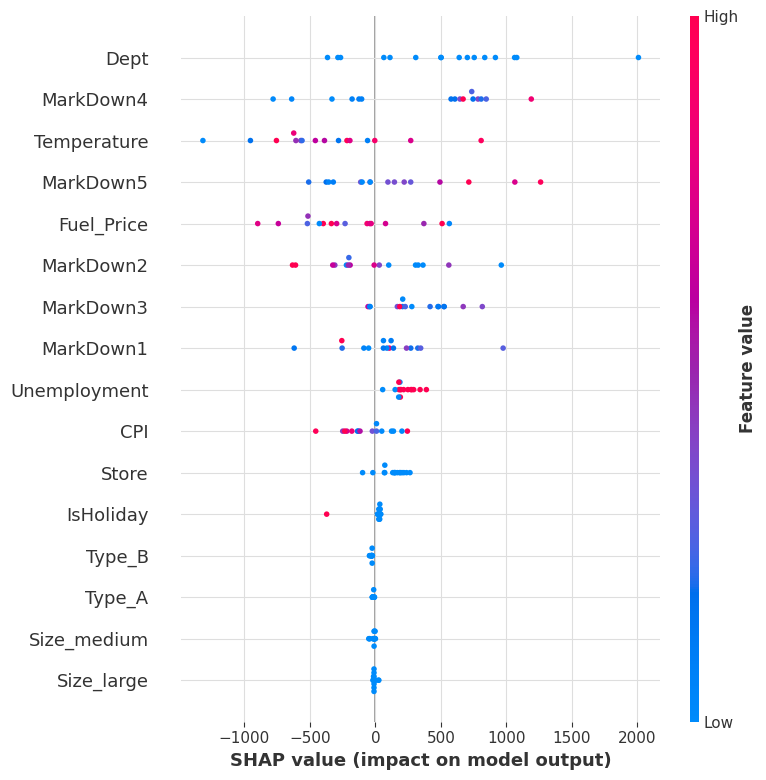

In [121]:
shap.summary_plot(shap_values, X_test_id)

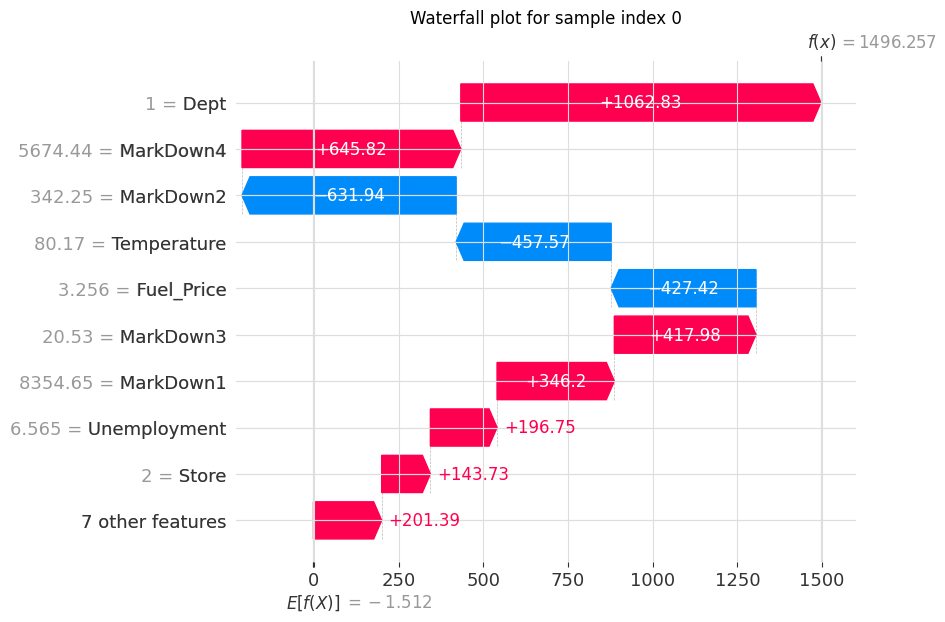

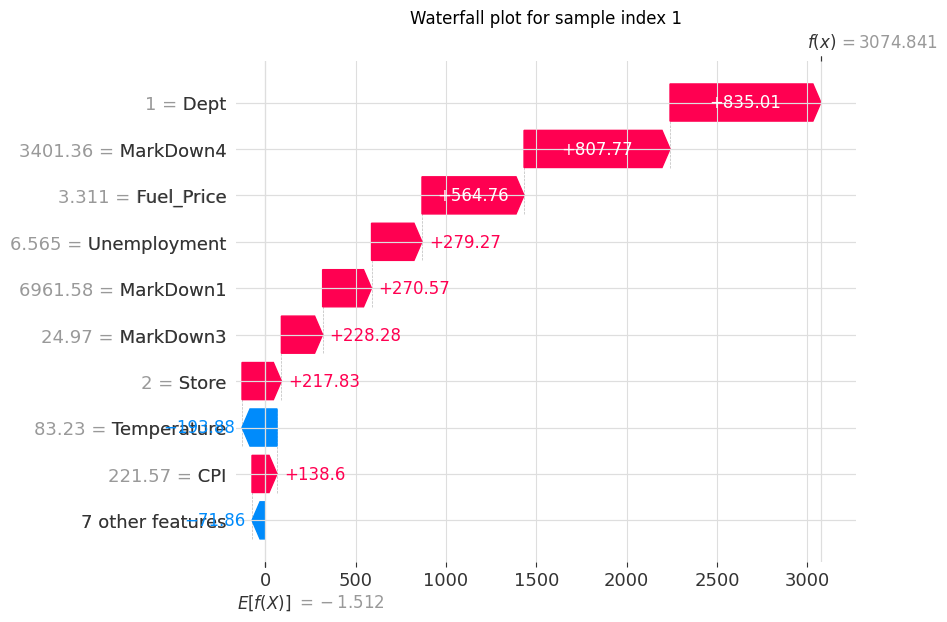

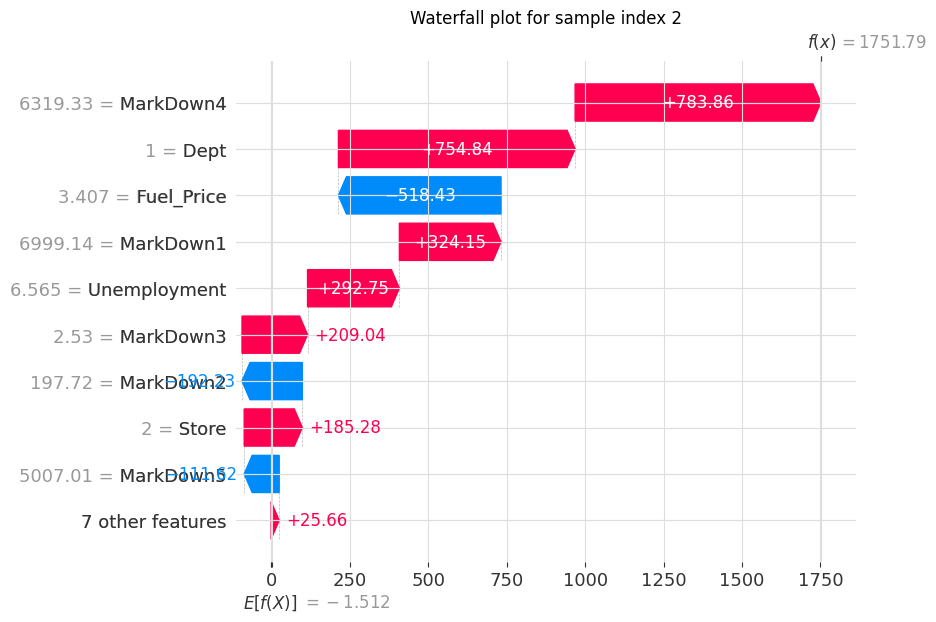

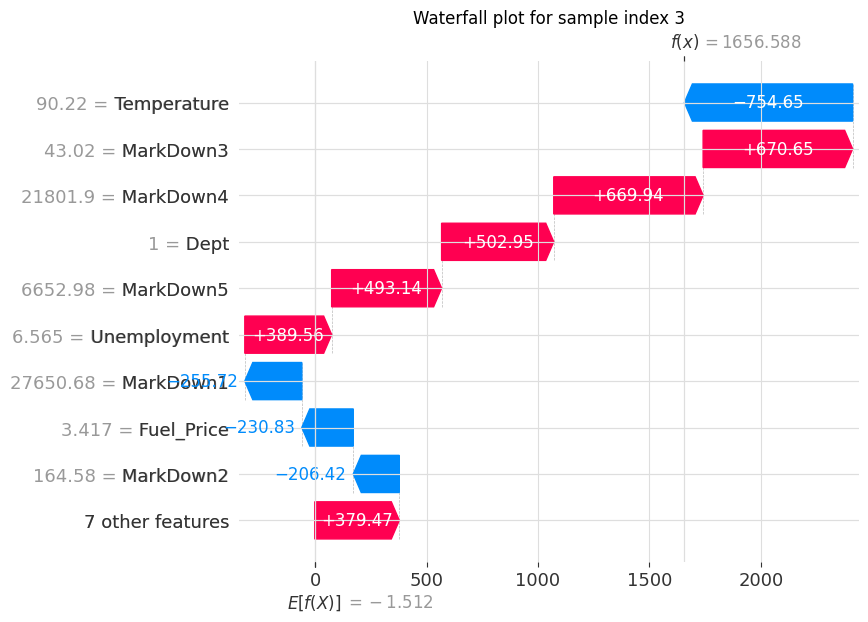

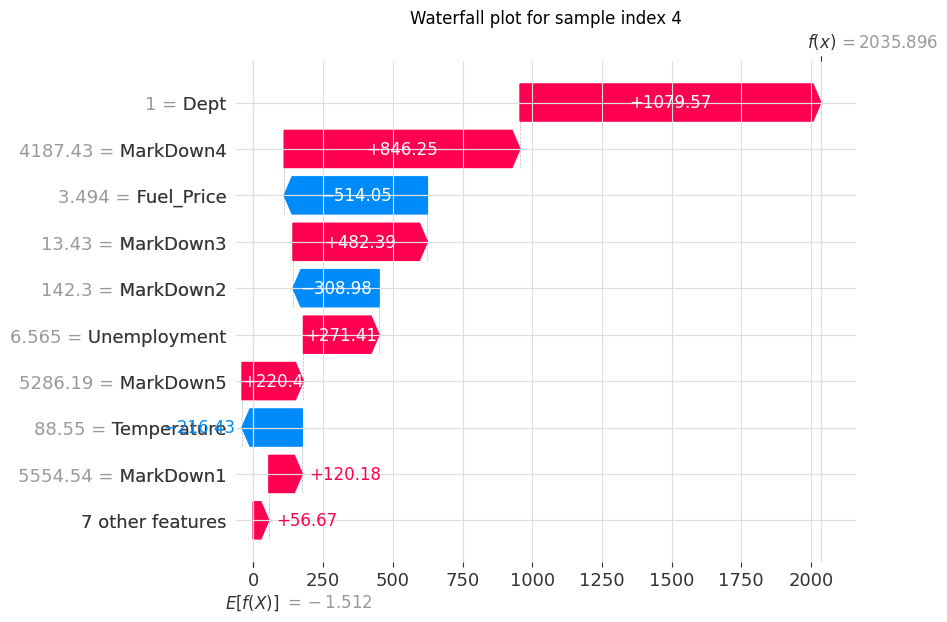

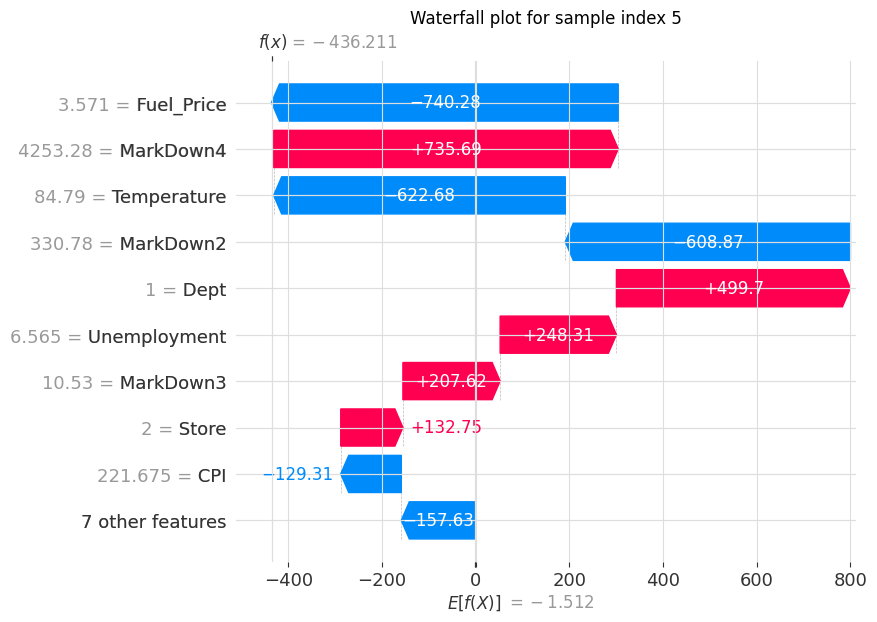

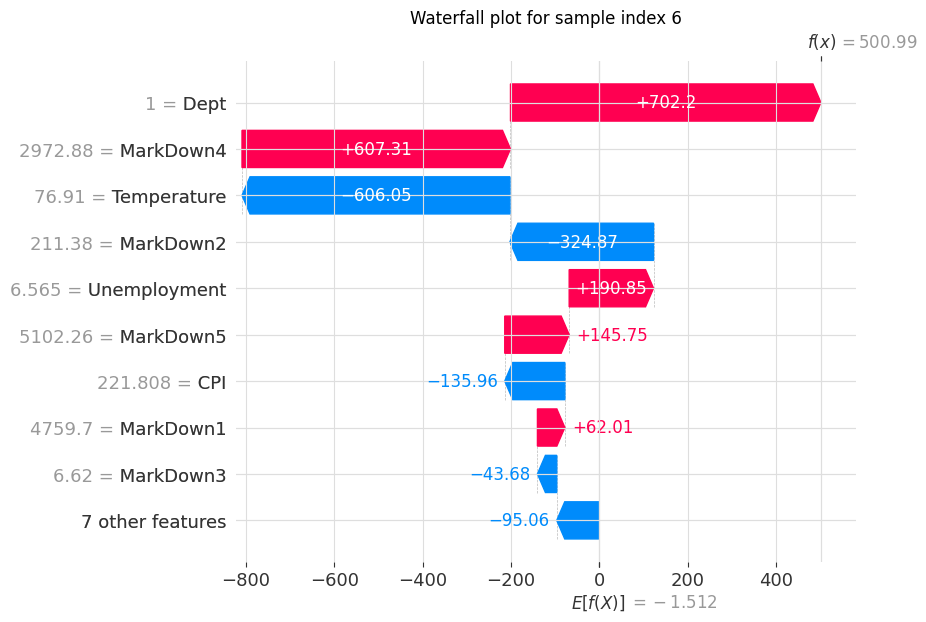

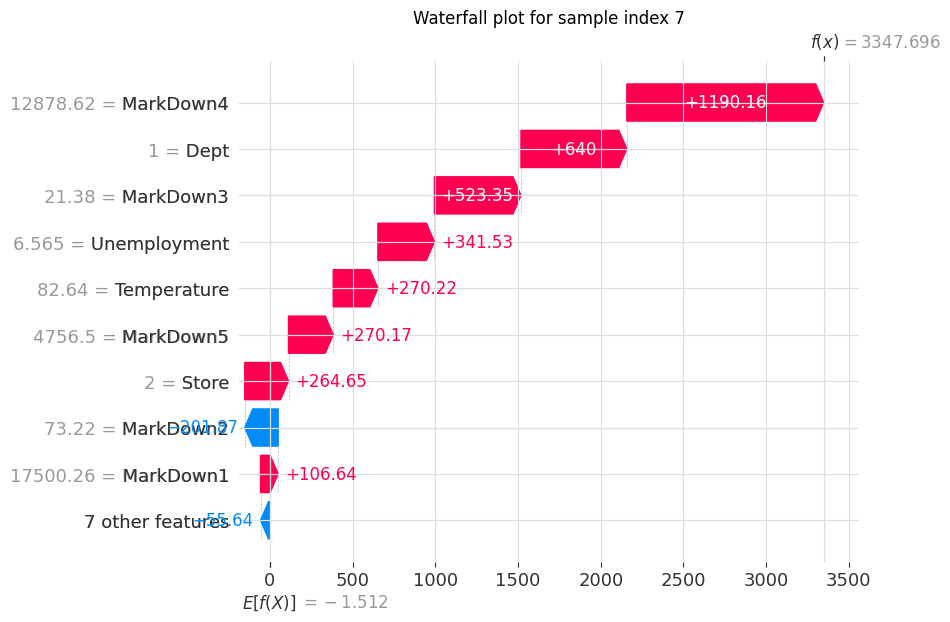

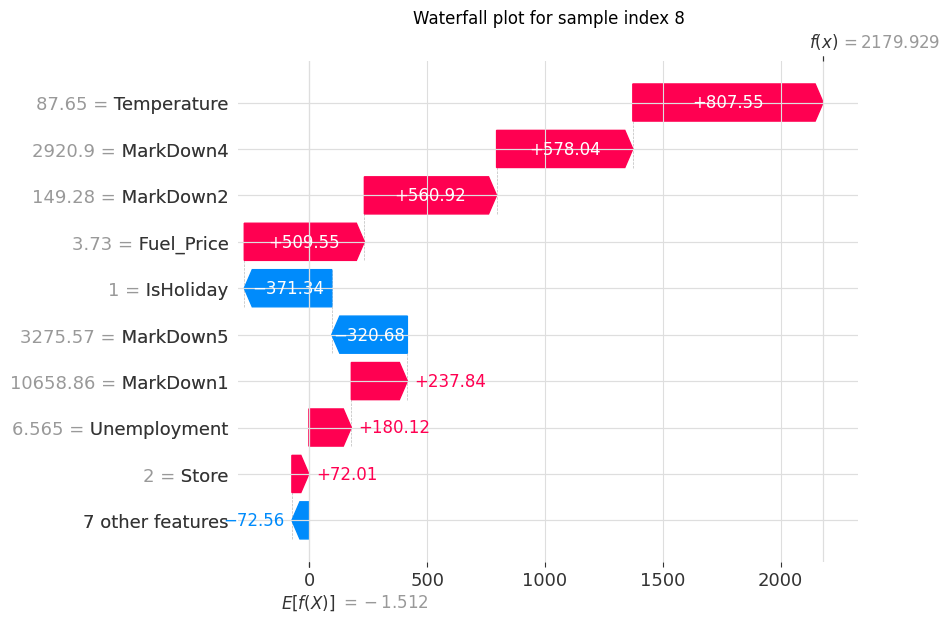

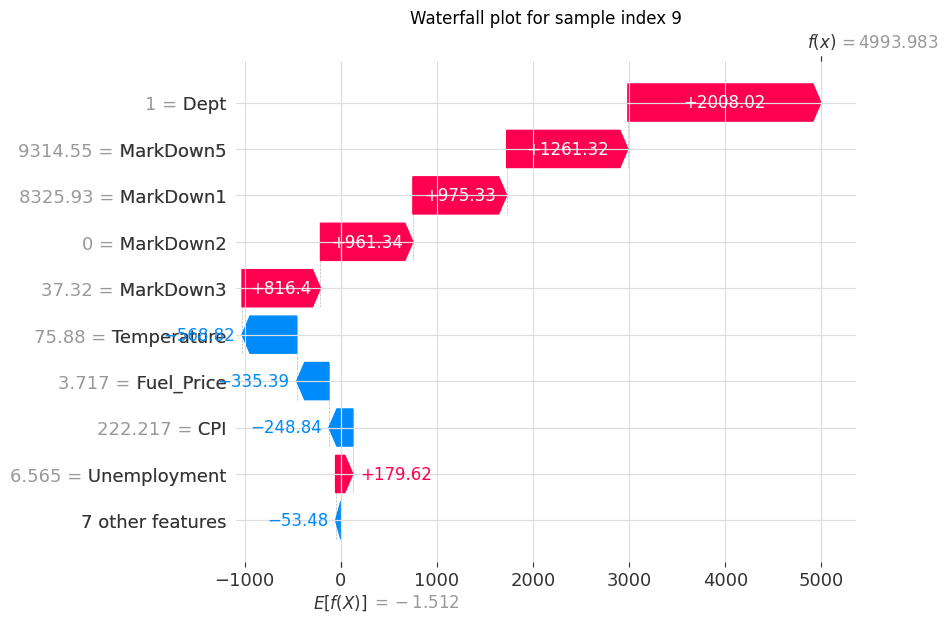

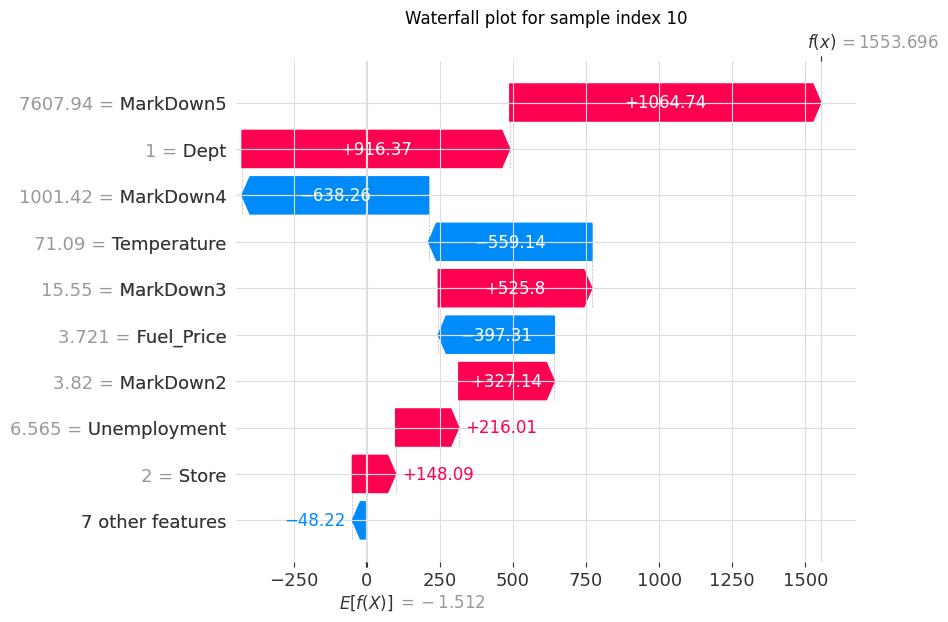

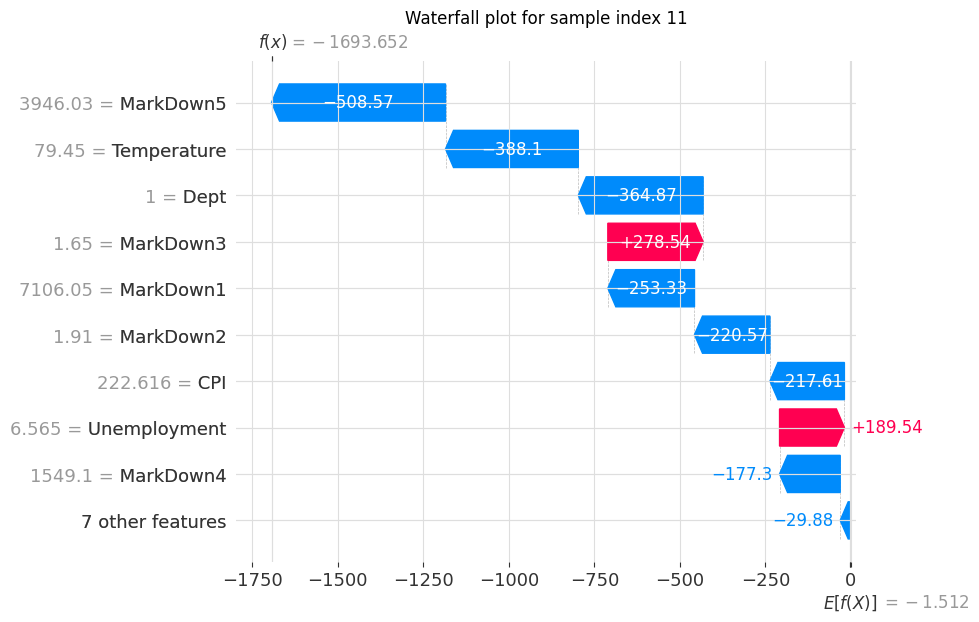

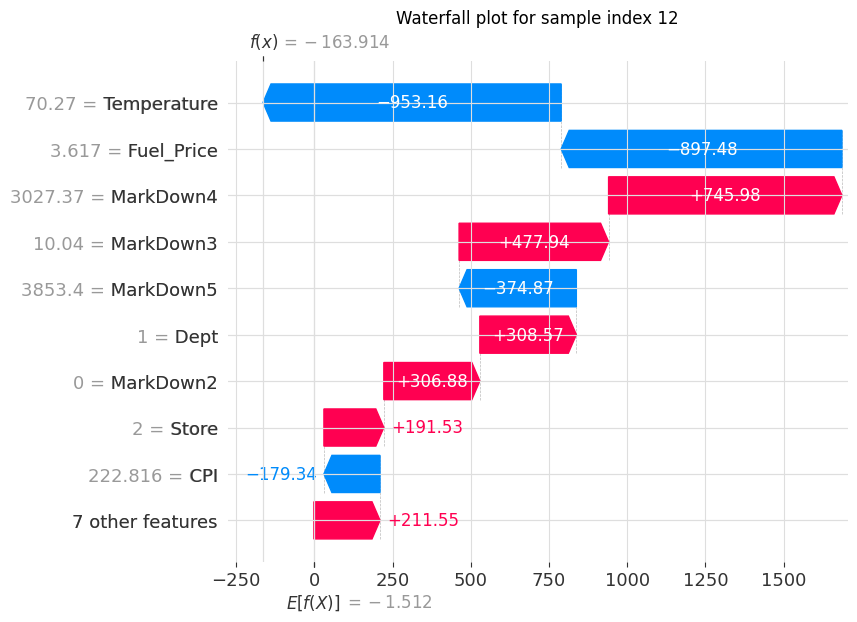

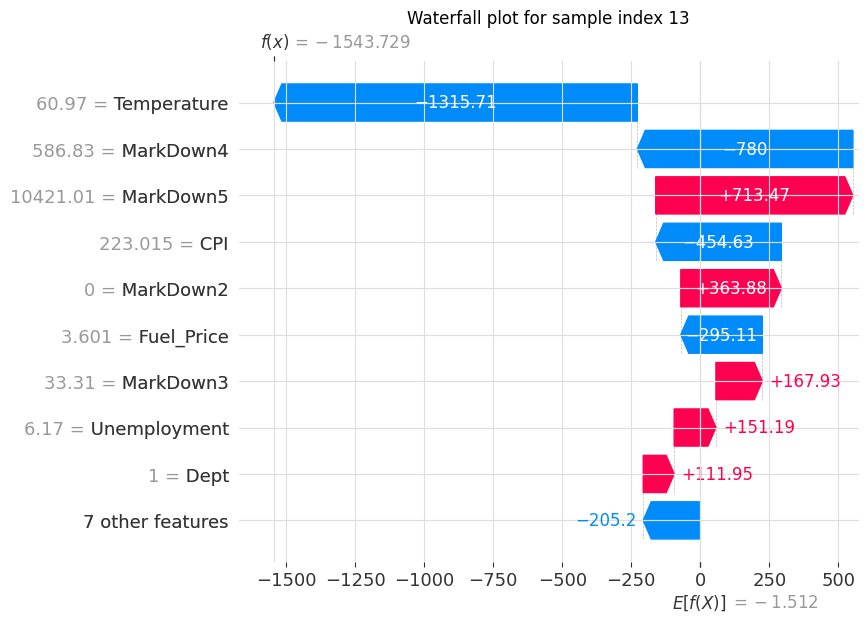

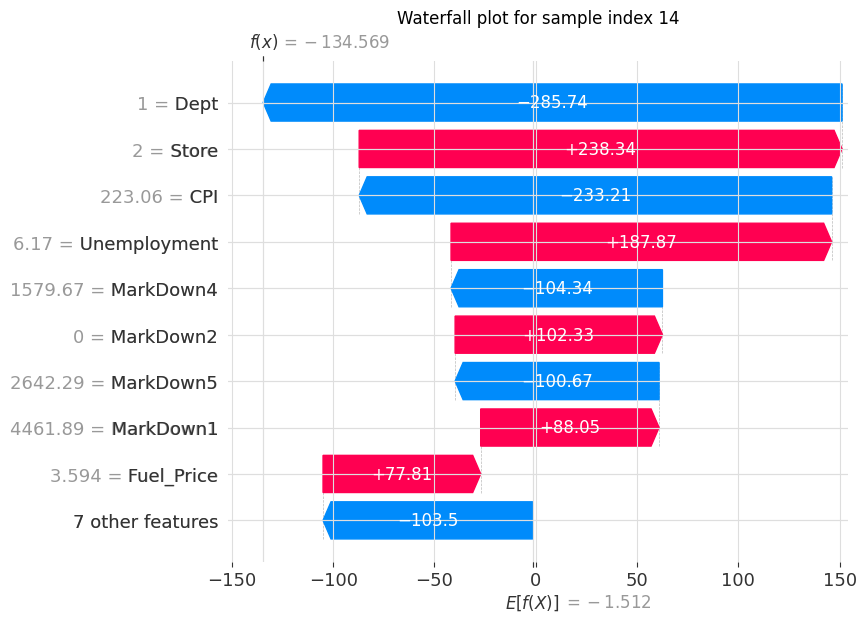

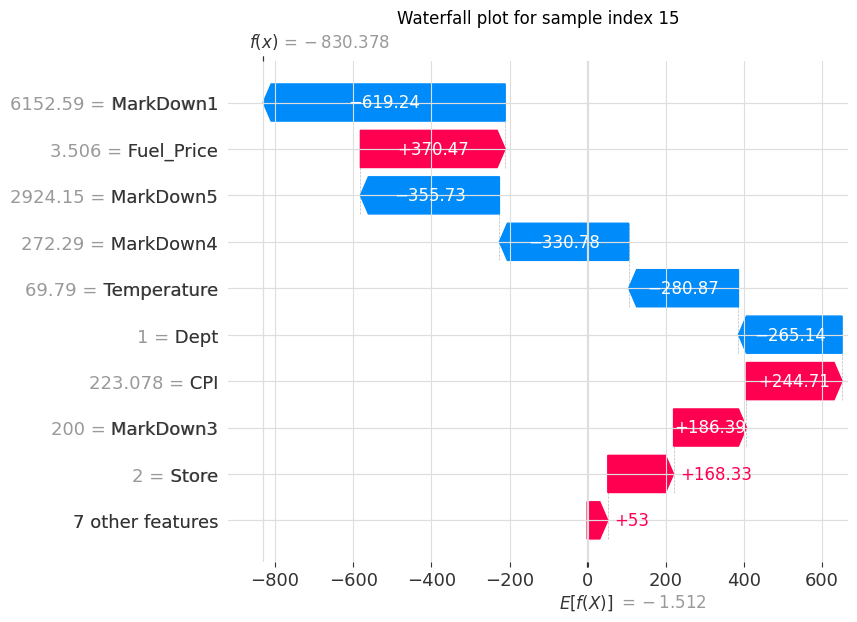

In [122]:
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0] 

explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,  # Valor(es) de base do modelo
    data=X_test_id.values,          # Dados de entrada
    feature_names=X_test_id.columns # Nomes das características
)

import matplotlib.pyplot as plt

for sample_ind in range(16): 
    plt.figure() 
    shap.plots.waterfall(explanation[sample_ind], show=False)
    plt.title(f"Waterfall plot for sample index {sample_ind}")
    plt.show()


In [123]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

best_tree_model = grid_search.best_estimator_

y_pred_tree = best_tree_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_tree, squared=False)
print("RMSE on residuals test set:", rmse)


Fitting 3 folds for each of 45 candidates, totalling 135 fits
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
RMSE on residuals test set: 5406.294352514316


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [124]:
forecast_final_tree= df_test['yhat']+y_pred_tree

print("RMSE on final forecast test set:", mean_squared_error(df_test['y'], forecast_final_tree, squared=False))

RMSE on final forecast test set: 5406.294352514317


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


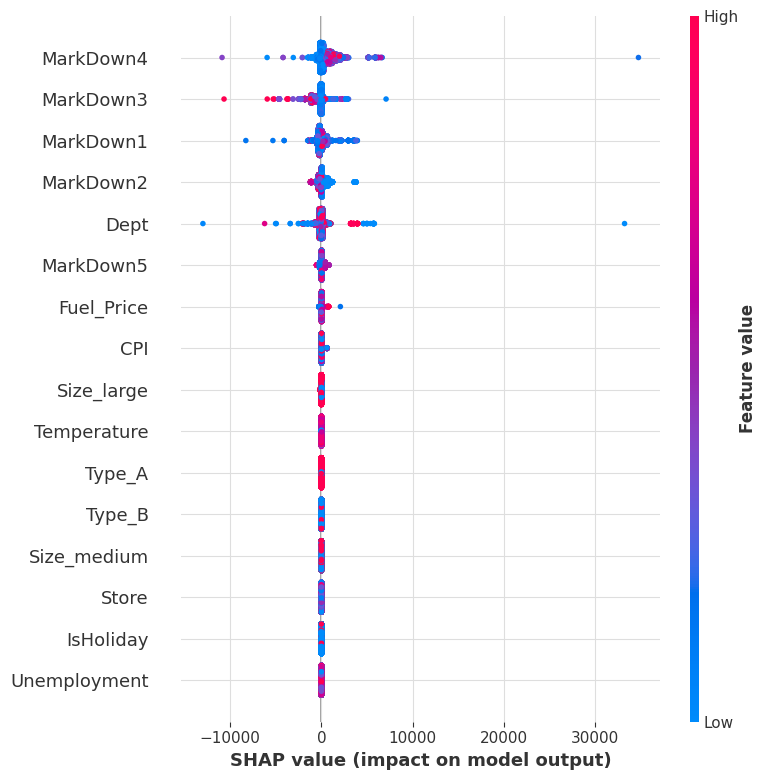

In [125]:
import pandas as pd
from catboost import CatBoostRegressor
import shap


explainer = shap.TreeExplainer(best_tree_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [126]:
shap_values = explainer.shap_values(X_test_id)

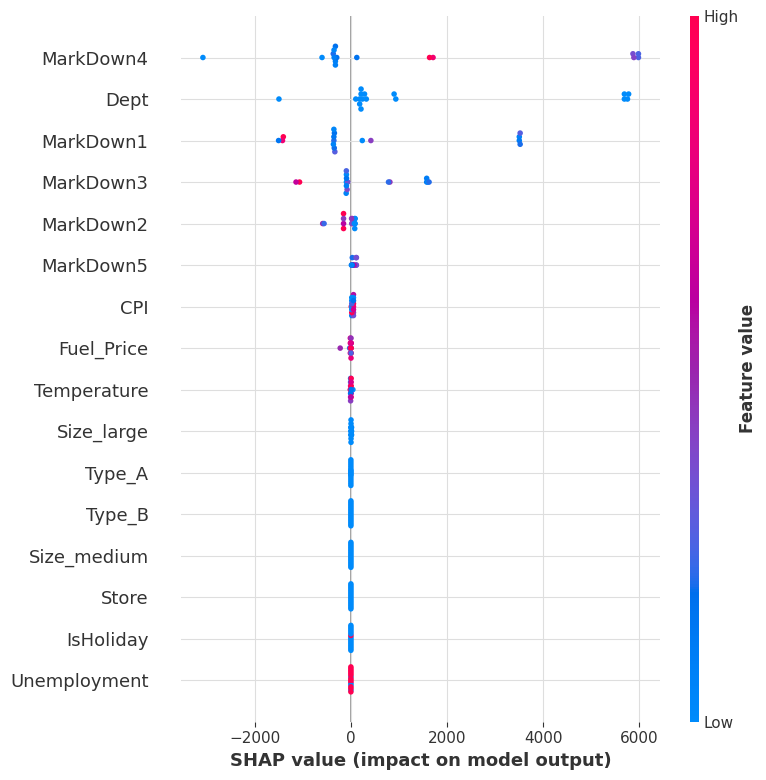

In [127]:
shap.summary_plot(shap_values, X_test_id)

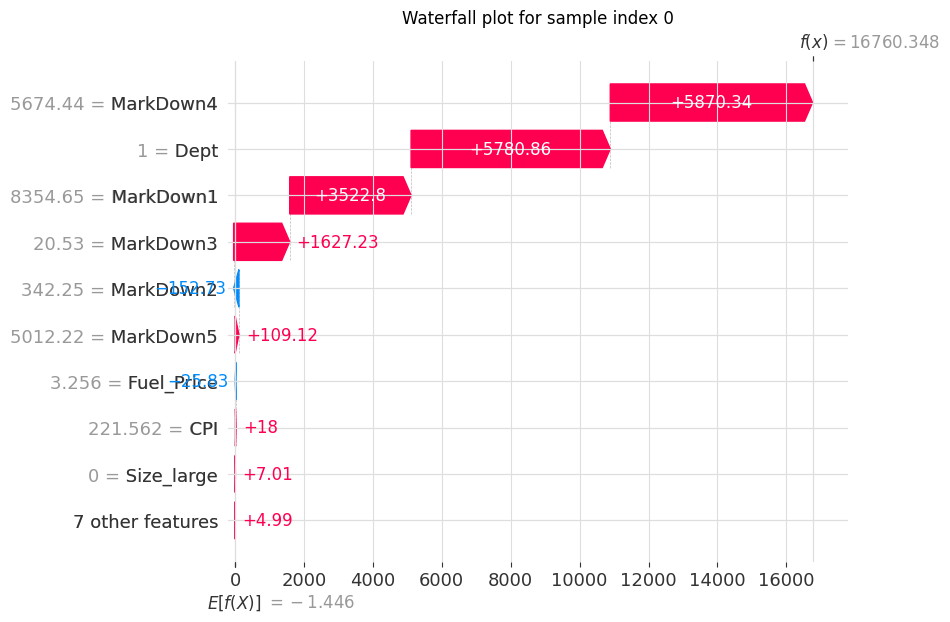

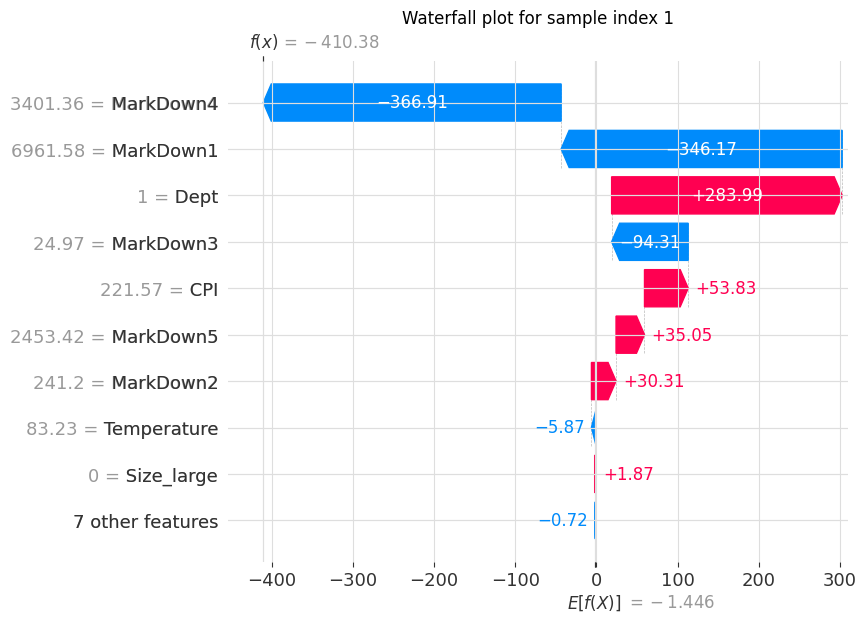

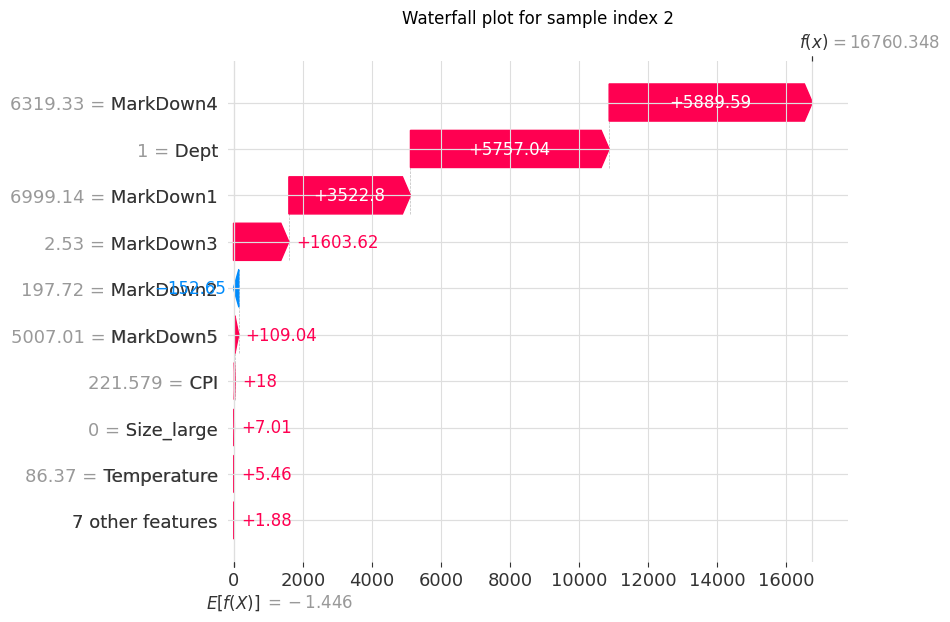

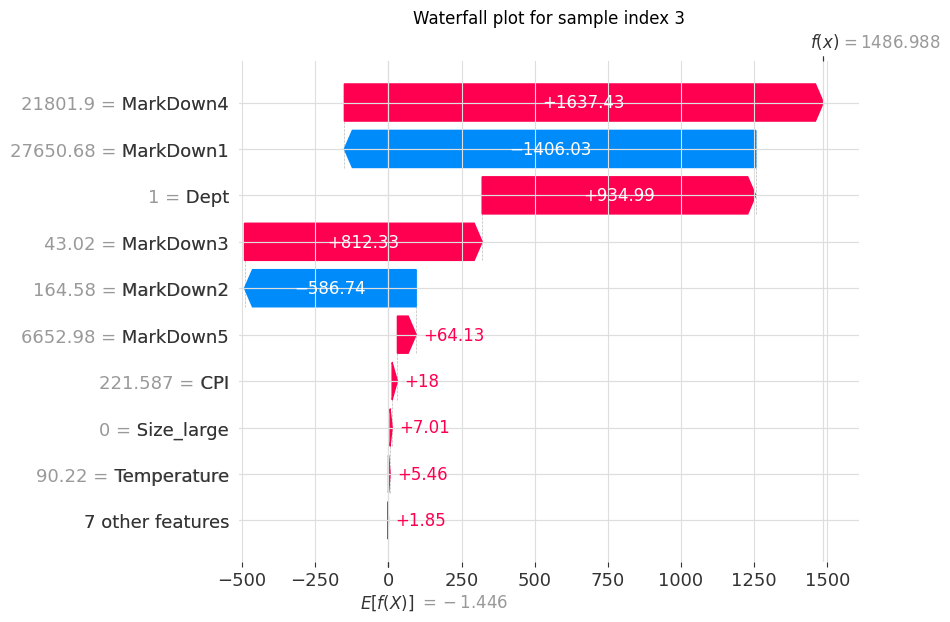

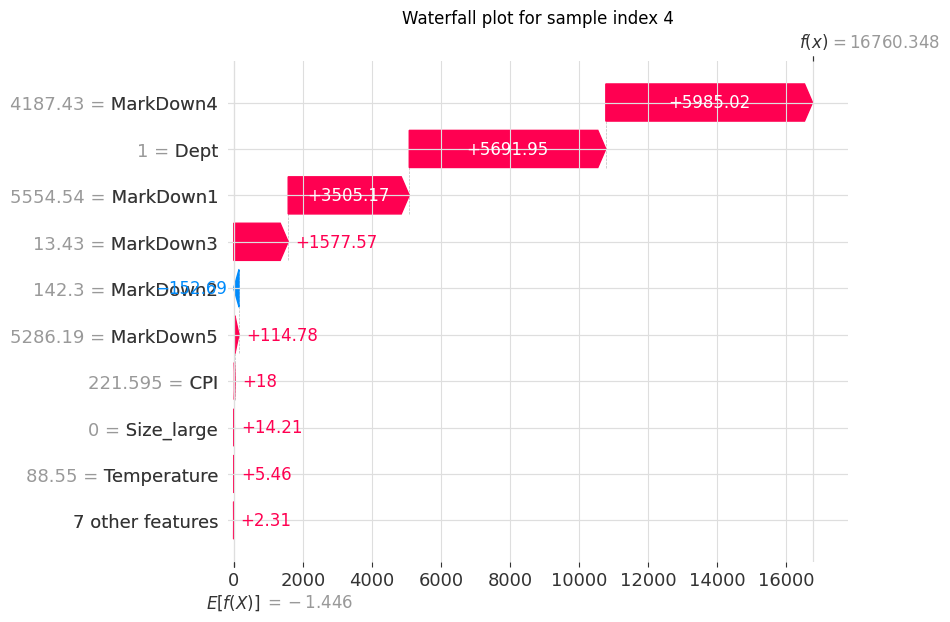

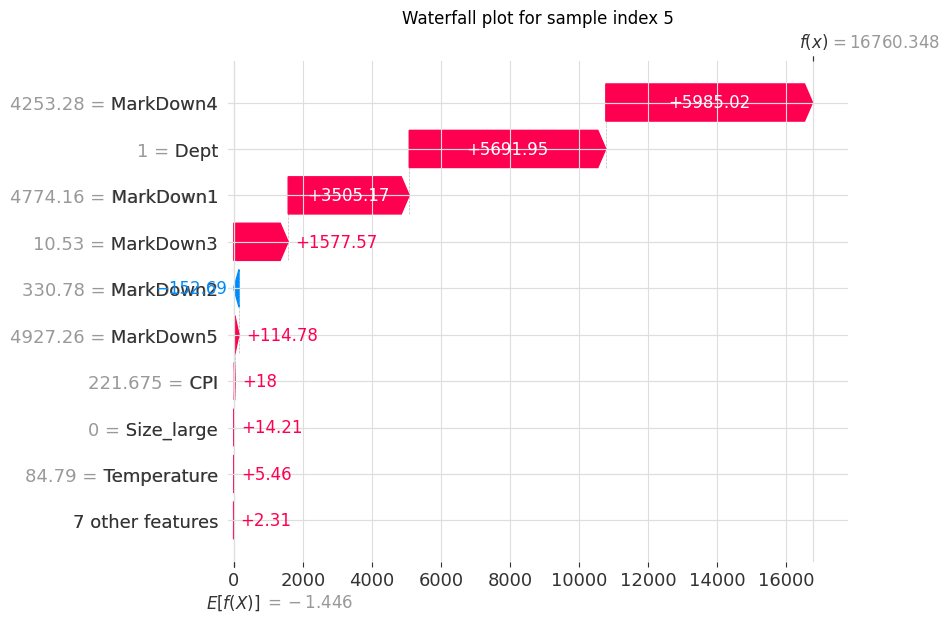

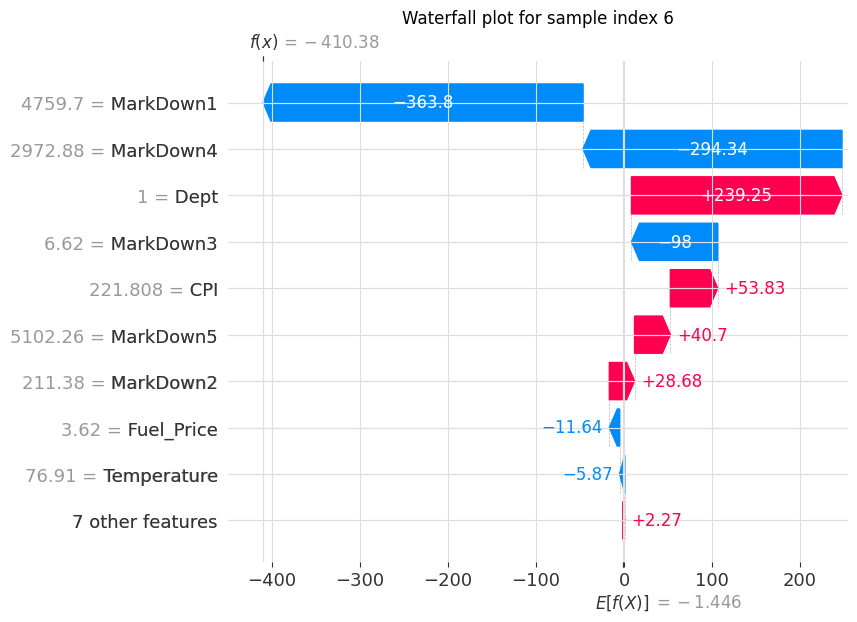

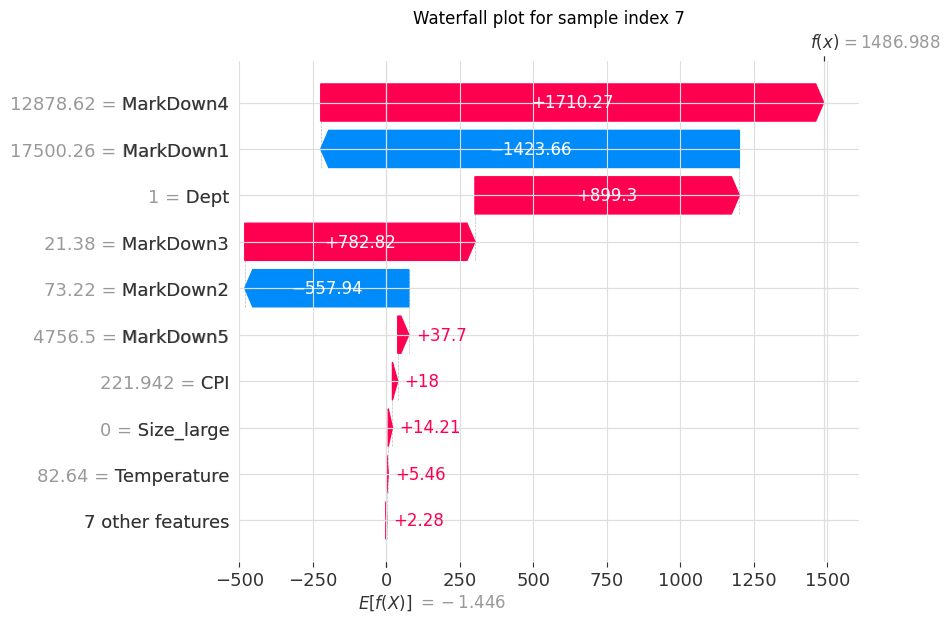

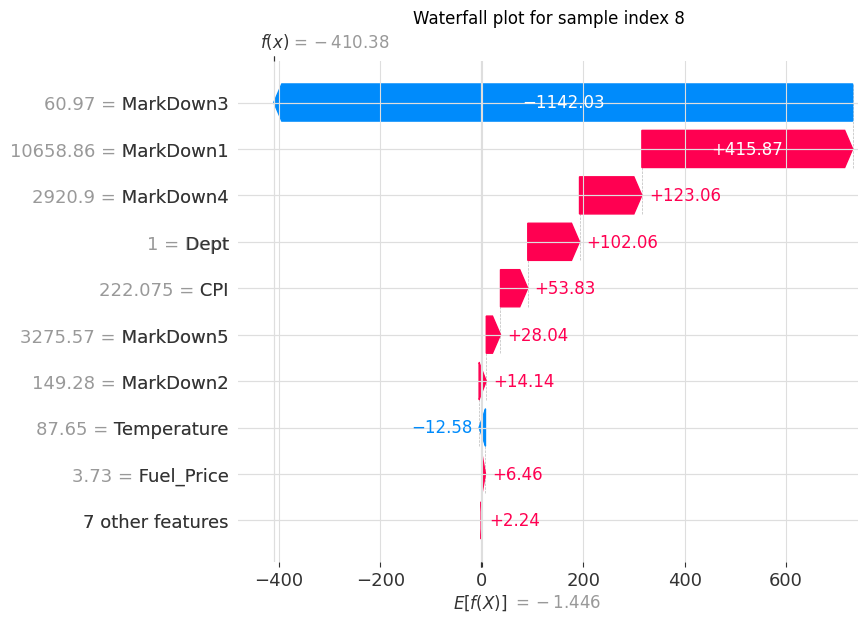

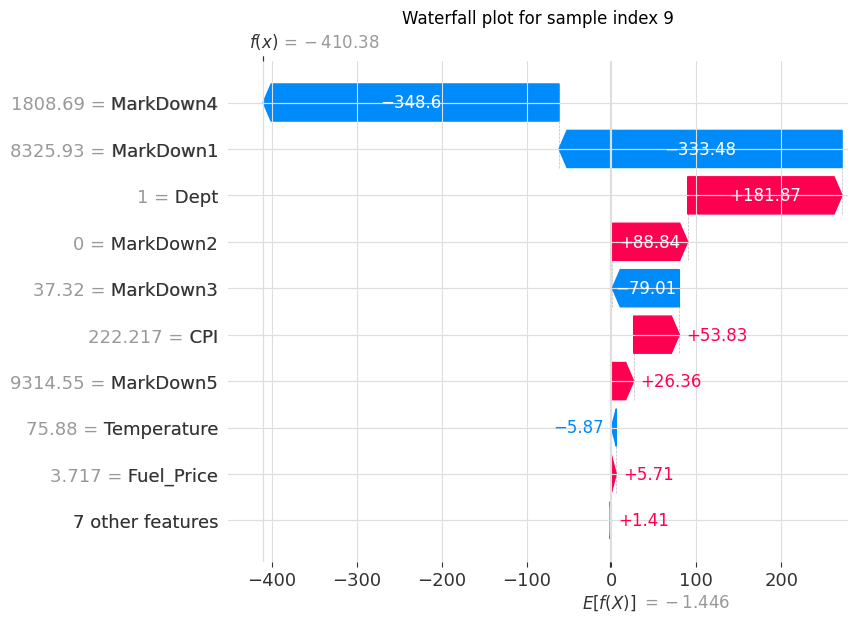

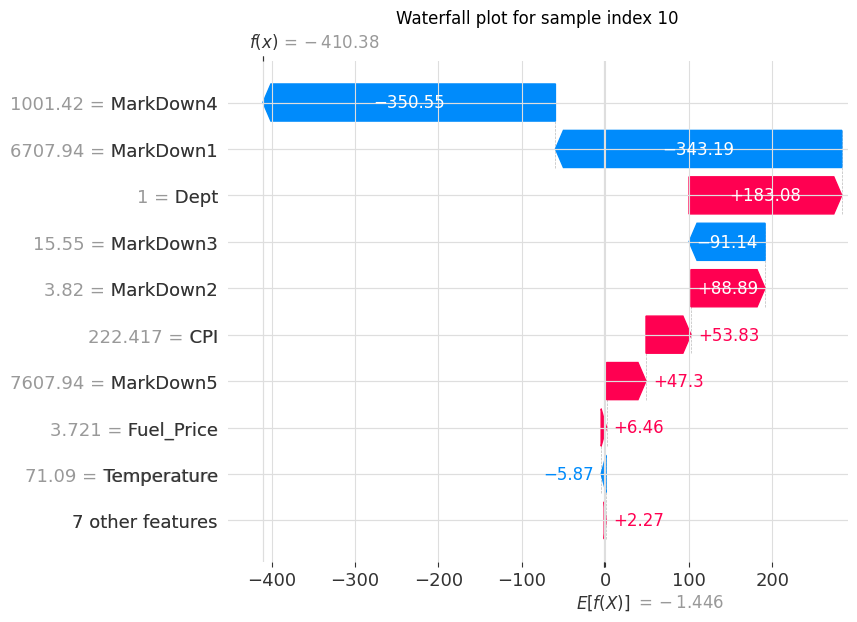

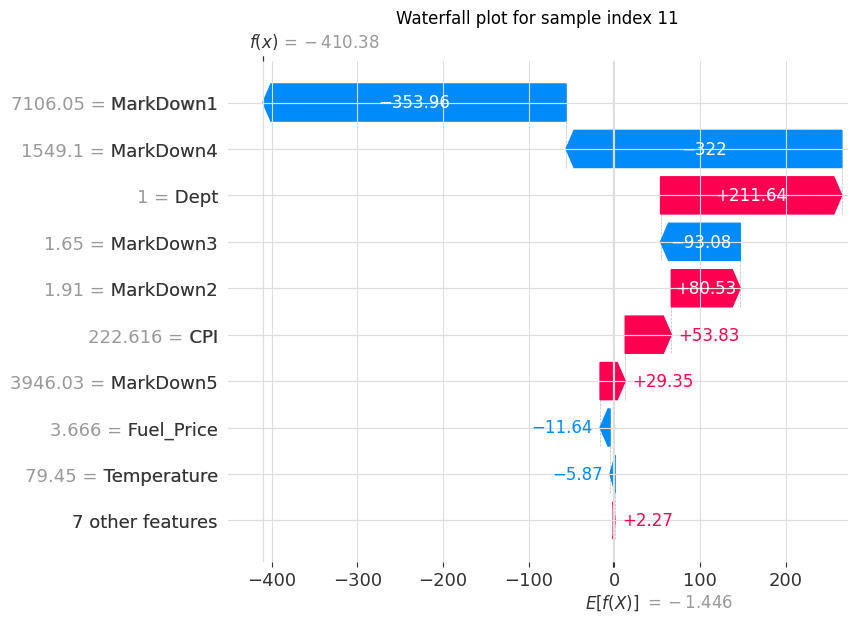

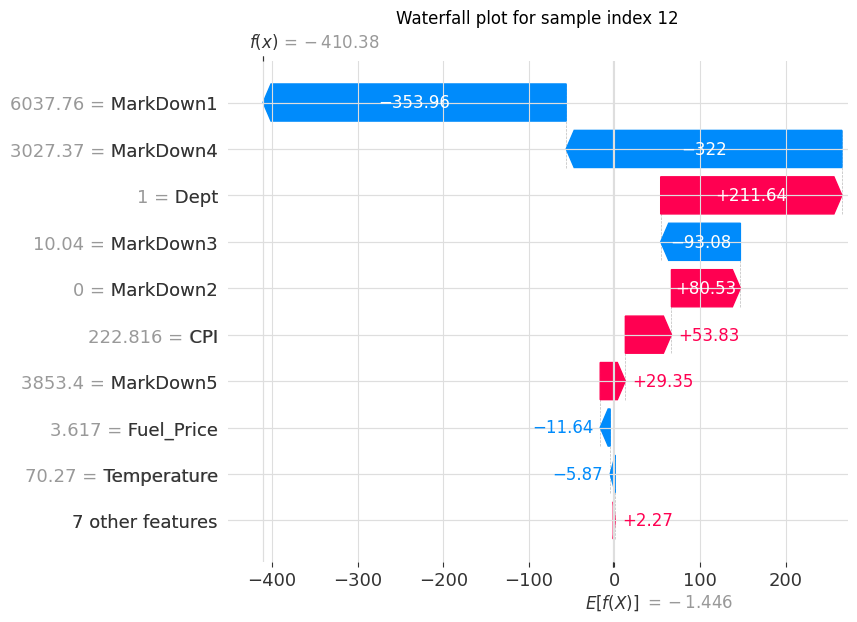

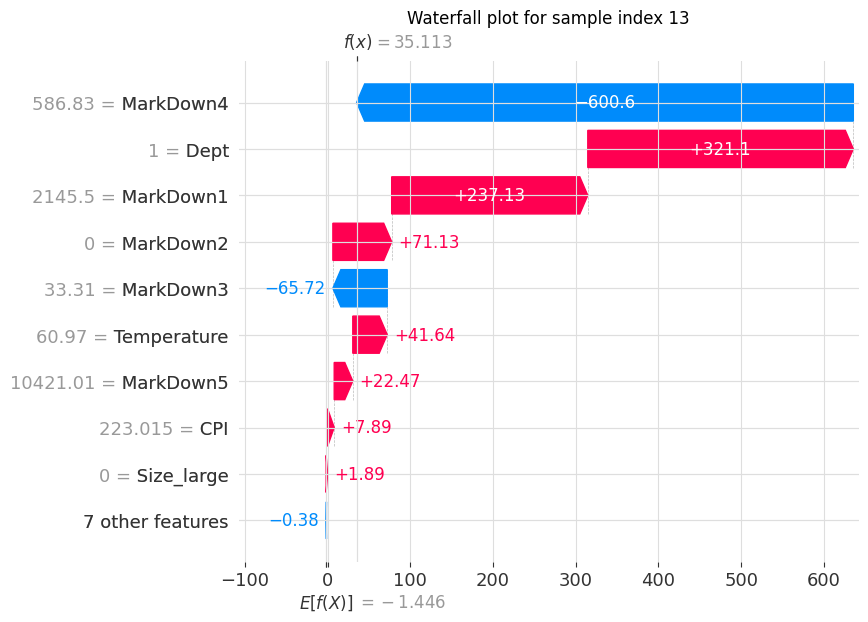

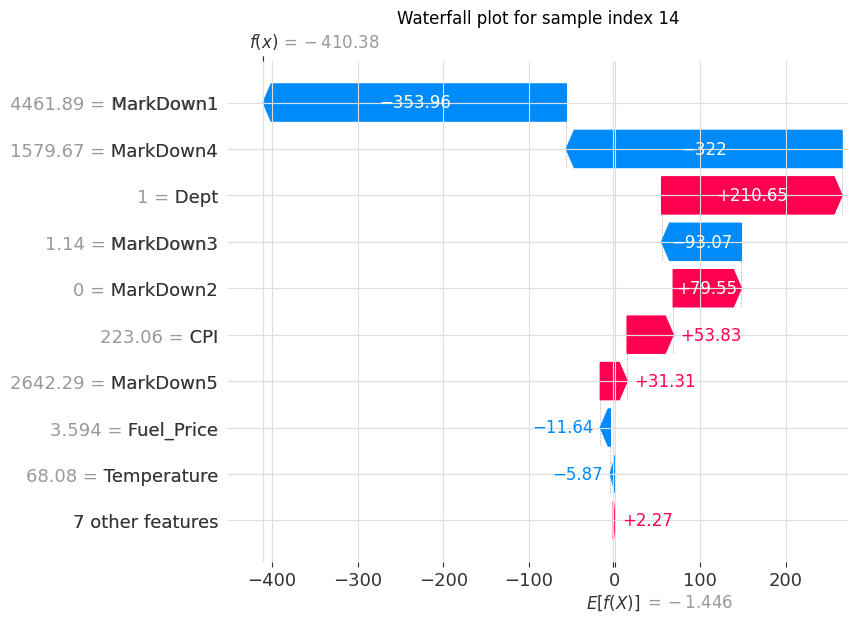

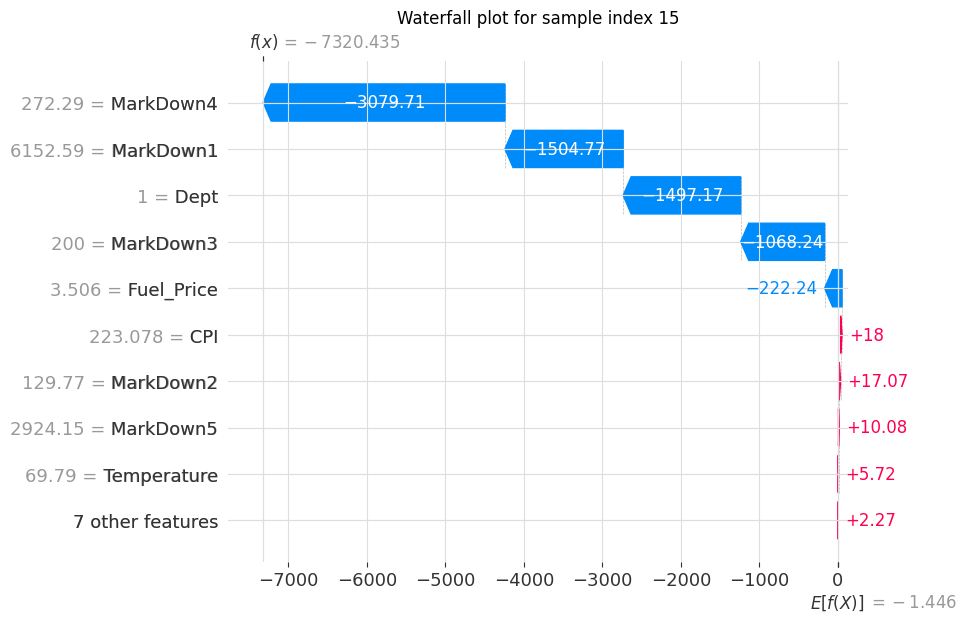

In [128]:
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0] 

explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,  # Valor(es) de base do modelo
    data=X_test_id.values,          # Dados de entrada
    feature_names=X_test_id.columns # Nomes das características
)

import matplotlib.pyplot as plt


for sample_ind in range(16):
    plt.figure() 
    shap.plots.waterfall(explanation[sample_ind], show=False)
    plt.title(f"Waterfall plot for sample index {sample_ind}")
    plt.show()

In [129]:
X_train

Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  \
0            54.34       2.962  126.442065         9.765          0   
1            49.96       2.828  126.496258         9.765          1   
2            58.22       2.915  126.526286         9.765          0   
3            52.77       2.825  126.552286         9.765          0   
4            55.92       2.877  126.578286         9.765          0   
...            ...         ...         ...           ...        ...   
59812        78.11       3.433  130.889677         4.308          0   
59813        80.94       3.372  130.829533         4.308          0   
59814        81.63       3.329  130.792900         4.308          0   
59815        84.23       3.257  130.756267         4.308          0   
59816        80.37       3.187  130.719633         4.077          0   

       MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  Store  Dept  \
0           0.00       0.00       0.00       0.00       0.00     10     1   
1           0.00       0.00       0.00       0.00       0.00     10     1   
2           0.00       0.00       0.00       0.00       0.00     10     1   
3           0.00       0.00       0.00       0.00       0.00     10     1   
4           0.00       0.00       0.00       0.00       0.00     10     1   
...          ...        ...        ...        ...        ...    ...   ...   
59812    7429.46     249.80       7.86    4235.27    9690.55      4    98   
59813   16063.84      84.00       0.22    2105.39    6113.16      4    98   
59814    6619.20     351.22       3.48    5390.02   10920.89      4    98   
59815    3756.11     211.60       0.00    2114.26    6371.15      4    98   
59816    9789.03      90.00     157.62   10671.47    3864.91      4    98   

       Size_large  Size_medium  Type_A  Type_B  
0               0            1       0       1  
1               0            1       0       1  
2               0            1       0       1  
3               0            1       0       1  
4               0            1       0       1  
...           ...          ...     ...     ...  
59812           1            0       1       0  
59813           1            0       1       0  
59814           1            0       1       0  
59815           1            0       1       0  
59816           1            0       1       0  

[59817 rows x 16 columns]

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Supondo que X_train, X_test, y_train, e y_test já estão definidos e que cat é a lista das colunas categóricas
#cat = ['Size_medium', 'Size_large', 'Type_A', 'Type_B']

cat = ['Size_large', 'Type_B']

X_train.drop(columns=['Size_medium','Type_A'])
X_test.drop(columns=['Size_medium','Type_A'])

# Inicialização do StandardScaler
scaler = StandardScaler()

# Escalonamento das características numéricas, excluindo as categóricas
X_train_scaled = scaler.fit_transform(X_train.drop(columns=cat))
X_test_scaled = scaler.transform(X_test.drop(columns=cat))

# Convertendo de volta para DataFrame para poder manipular mais facilmente
X_train_scaled = pd.DataFrame(X_train_scaled, columns=[col for col in X_train.columns if col not in cat], index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=[col for col in X_test.columns if col not in cat], index=X_test.index)

X_train_scaled = pd.concat([X_train_scaled, X_train[cat]], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[cat]], axis=1)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Previsão e cálculo do RMSE
y_pred = model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")


RMSE: 4915.485175077223


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [145]:
forecast_final_lr= df_test['yhat']+y_pred
print("RMSE on final forecast test set:", mean_squared_error(df_test['y'], forecast_final_lr, squared=False))

RMSE on final forecast test set: 4915.485175077223


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [146]:
print(X_test_scaled.dtypes)


Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
IsHoliday       float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
Store           float64
Dept            float64
Size_medium     float64
Type_A          float64
Size_large        int64
Type_B            int64
dtype: object


In [147]:
explainer = shap.Explainer(model.predict, X_test_scaled, feature_names=X_test_scaled.columns)
shap_values = explainer(X_test_scaled)

PermutationExplainer explainer: 7537it [01:39, 69.19it/s]                          


In [148]:
X_test

Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  MarkDown1  \
0           89.80       3.723  130.683000         7.170          0    7069.25   
1           84.45       3.589  130.701290         7.170          0    6596.80   
2           83.98       3.769  130.719581         7.170          0    9511.34   
3           84.76       3.595  130.737871         7.170          0   37194.44   
4           90.78       3.811  130.756161         7.170          0   15282.47   
...           ...         ...         ...           ...        ...        ...   
7531        71.74       3.666  131.043000         4.077          0    5333.92   
7532        63.07       3.620  131.075667         3.879          0    5918.34   
7533        57.11       3.603  131.108333         3.879          0    4975.39   
7534        64.46       3.610  131.149968         3.879          0    6313.84   
7535        63.64       3.514  131.193097         3.879          0    1763.13   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5  Store  Dept  Size_large  \
0          5.00       0.32    8194.36    1372.82     10     1           0   
1         -1.60      44.60    4275.27   10650.28     10     1           0   
2          0.00       8.87   16376.33    3062.22     10     1           0   
3          0.00      53.40   21623.93    2549.27     10     1           0   
4          0.00      58.80    5537.01   14827.71     10     1           0   
...         ...        ...        ...        ...    ...   ...         ...   
7531       5.73       2.94    1931.02    9753.37      4    98           1   
7532       0.00     126.57    3674.49    6807.07      4    98           1   
7533       0.00      61.17    1513.17    5905.53      4    98           1   
7534       0.00      15.05    2421.08    5885.12      4    98           1   
7535      88.76      66.76       0.00    7577.14      4    98           1   

      Size_medium  Type_A  Type_B  
0               1       0       1  
1               1       0       1  
2               1       0       1  
3               1       0       1  
4               1       0       1  
...           ...     ...     ...  
7531            0       1       0  
7532            0       1       0  
7533            0       1       0  
7534            0       1       0  
7535            0       1       0  

[7536 rows x 16 columns]

In [149]:
X_test_scaled

Temperature  Fuel_Price       CPI  Unemployment  IsHoliday  MarkDown1  \
0        1.749334    0.855722 -0.837722     -0.471642  -0.276172   0.542409   
1        1.441099    0.558085 -0.837224     -0.471642  -0.276172   0.479175   
2        1.414020    0.957896 -0.836727     -0.471642  -0.276172   0.869265   
3        1.458959    0.571412 -0.836229     -0.471642  -0.276172   4.574448   
4        1.805796    1.051185 -0.835731     -0.471642  -0.276172   1.641689   
...           ...         ...       ...           ...        ...        ...   
7531     0.708824    0.729115 -0.827926     -3.435519  -0.276172   0.310147   
7532     0.209310    0.626941 -0.827037     -3.625253  -0.276172   0.388368   
7533    -0.134069    0.589181 -0.826148     -3.625253  -0.276172   0.262161   
7534     0.289394    0.604729 -0.825015     -3.625253  -0.276172   0.441303   
7535     0.242151    0.391497 -0.823841     -3.625253  -0.276172  -0.167777   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5     Store      Dept  \
0     -0.203306  -0.102838   1.317920  -0.094790 -0.350125 -1.424713   
1     -0.204063  -0.097826   0.565479   2.112384 -0.350125 -1.424713   
2     -0.203880  -0.101871   2.888808   0.307130 -0.350125 -1.424713   
3     -0.203880  -0.096830   3.896315   0.185096 -0.350125 -1.424713   
4     -0.203880  -0.096219   0.807725   3.106224 -0.350125 -1.424713   
...         ...        ...        ...        ...       ...       ...   
7531  -0.203223  -0.102542   0.115397   1.899003 -1.094073  1.796013   
7532  -0.203880  -0.088547   0.450133   1.198057 -1.094073  1.796013   
7533  -0.203880  -0.095950   0.035173   0.983574 -1.094073  1.796013   
7534  -0.203880  -0.101171   0.209486   0.978718 -1.094073  1.796013   
7535  -0.193701  -0.095317  -0.255346   1.381262 -1.094073  1.796013   

      Size_medium    Type_A  Size_large  Type_B  
0        1.159001 -2.455575           0       1  
1        1.159001 -2.455575           0       1  
2        1.159001 -2.455575           0       1  
3        1.159001 -2.455575           0       1  
4        1.159001 -2.455575           0       1  
...           ...       ...         ...     ...  
7531    -0.862812  0.407237           1       0  
7532    -0.862812  0.407237           1       0  
7533    -0.862812  0.407237           1       0  
7534    -0.862812  0.407237           1       0  
7535    -0.862812  0.407237           1       0  

[7536 rows x 16 columns]

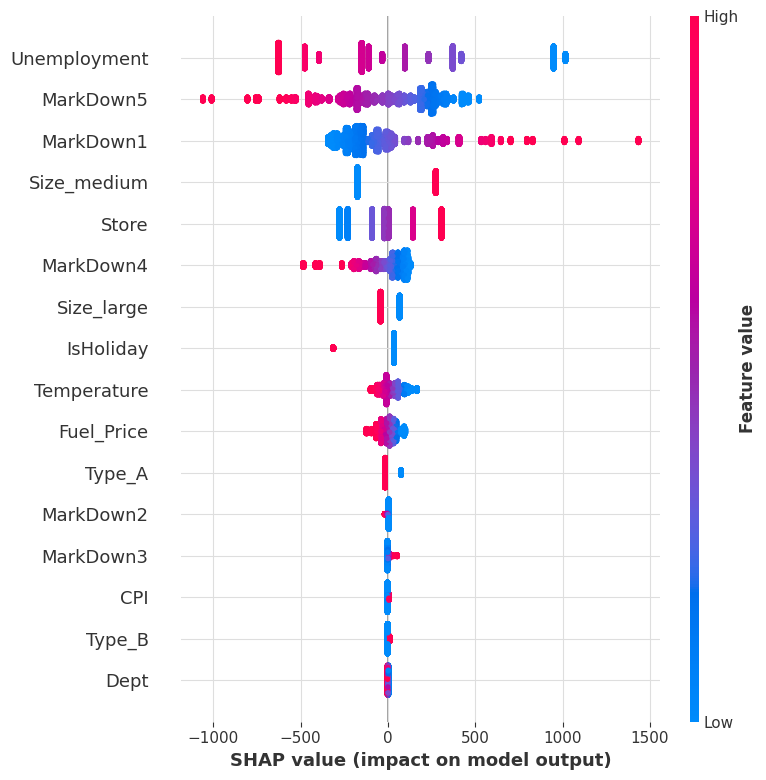

In [150]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns)


In [151]:
X_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_scaled_df['id'] = df_test['id'] 

X_filtered = X_scaled_df[X_scaled_df['id'] == '2-1']
shap_values_filtered = explainer(X_filtered.drop('id', axis=1))


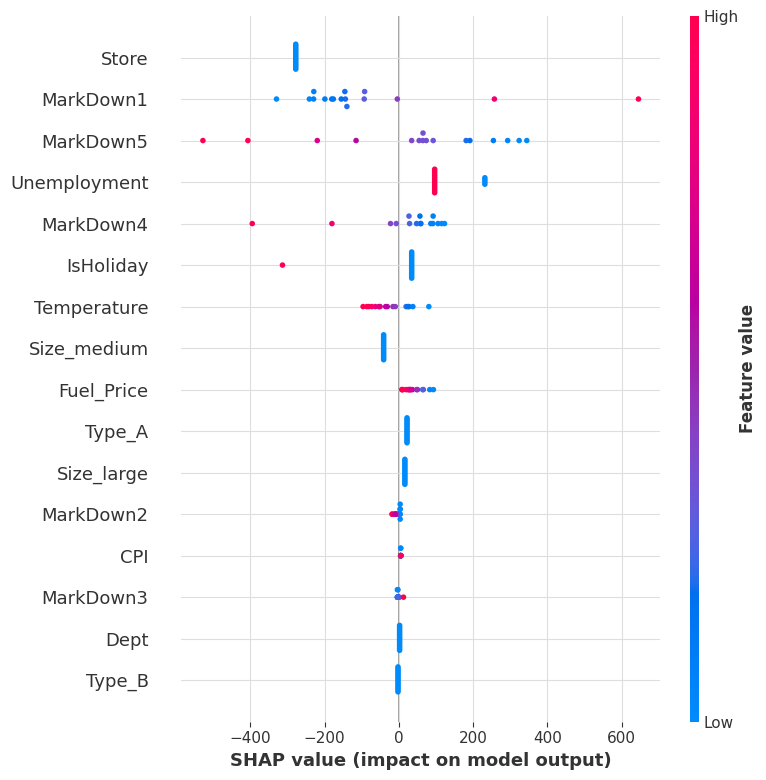

In [152]:
shap.summary_plot(shap_values_filtered, X_filtered.drop('id',axis=1), feature_names=X_test.columns)

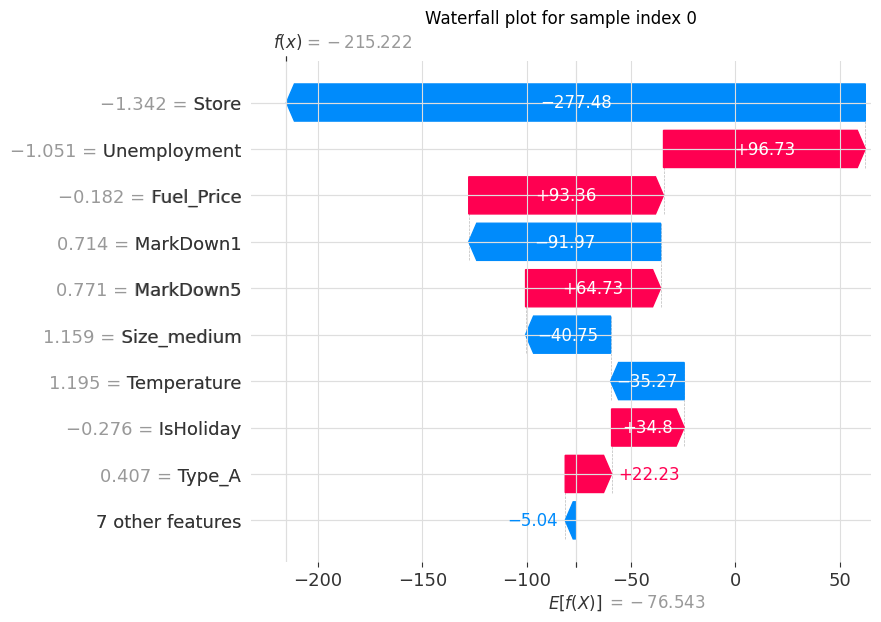

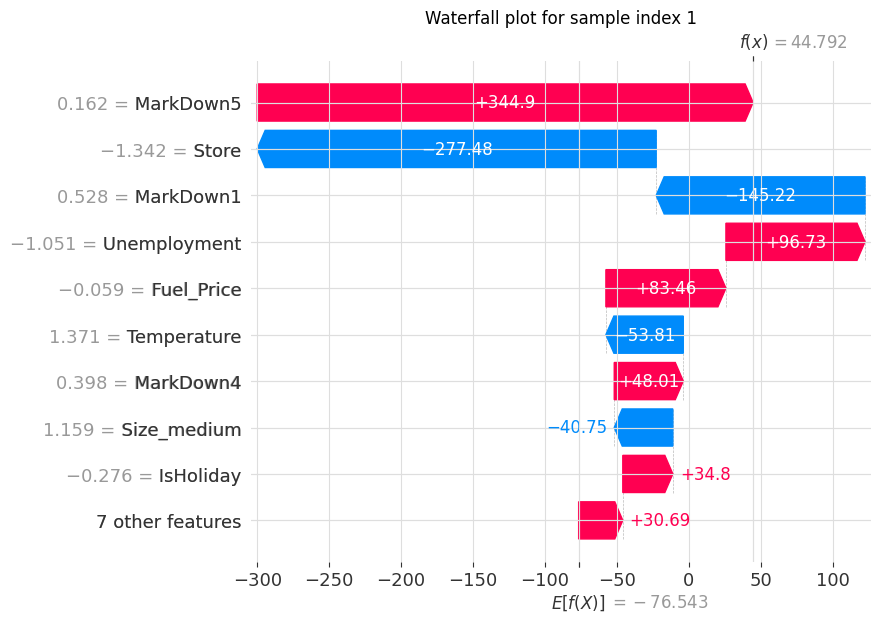

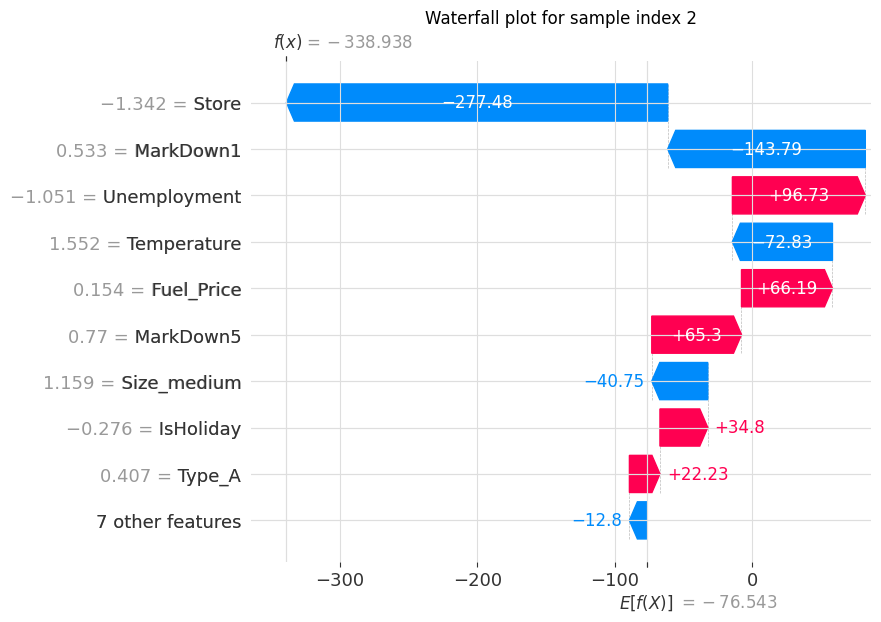

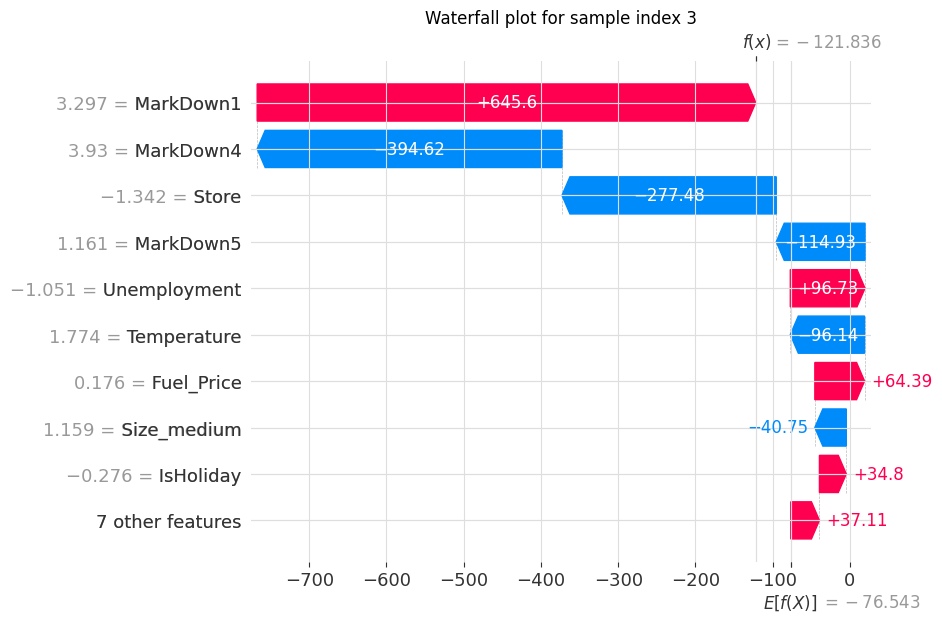

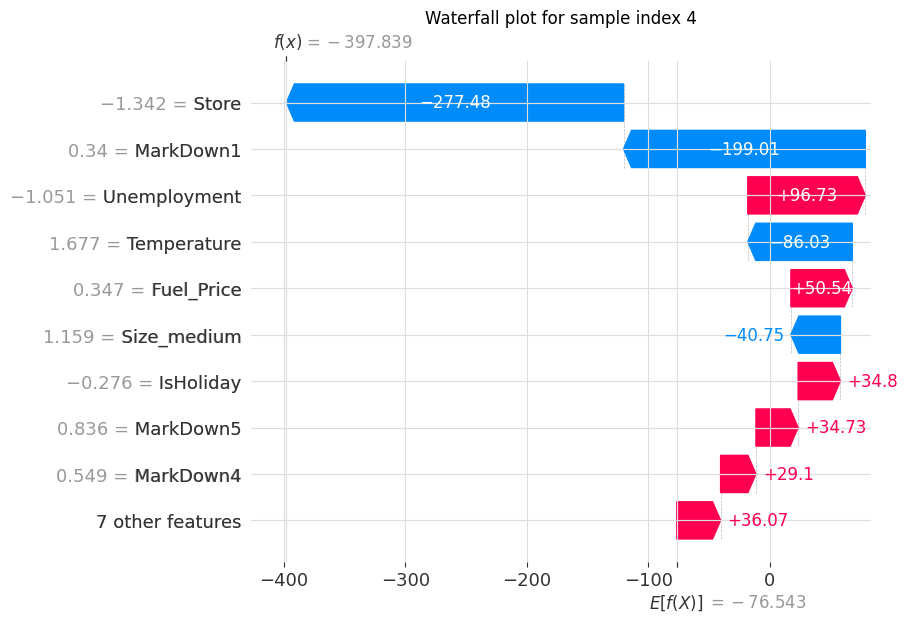

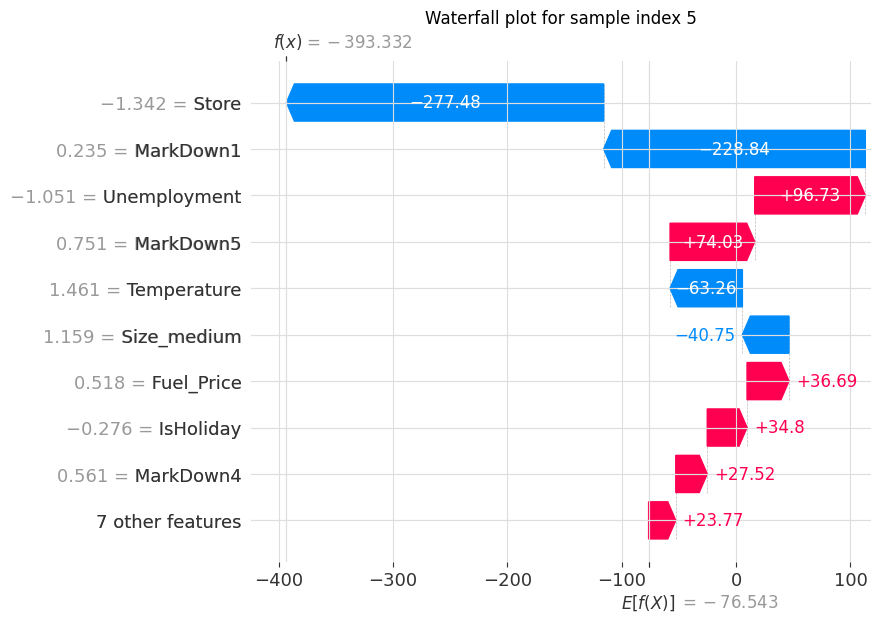

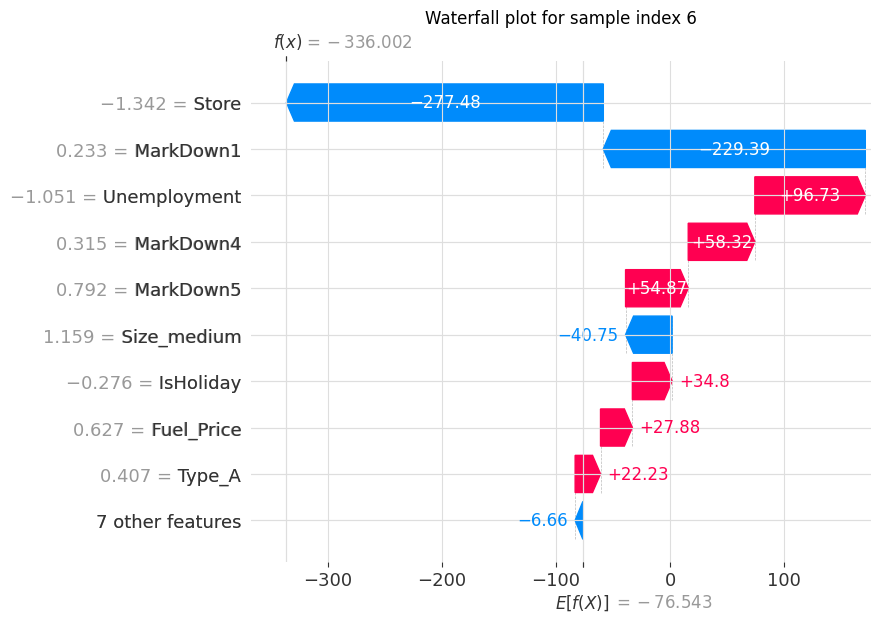

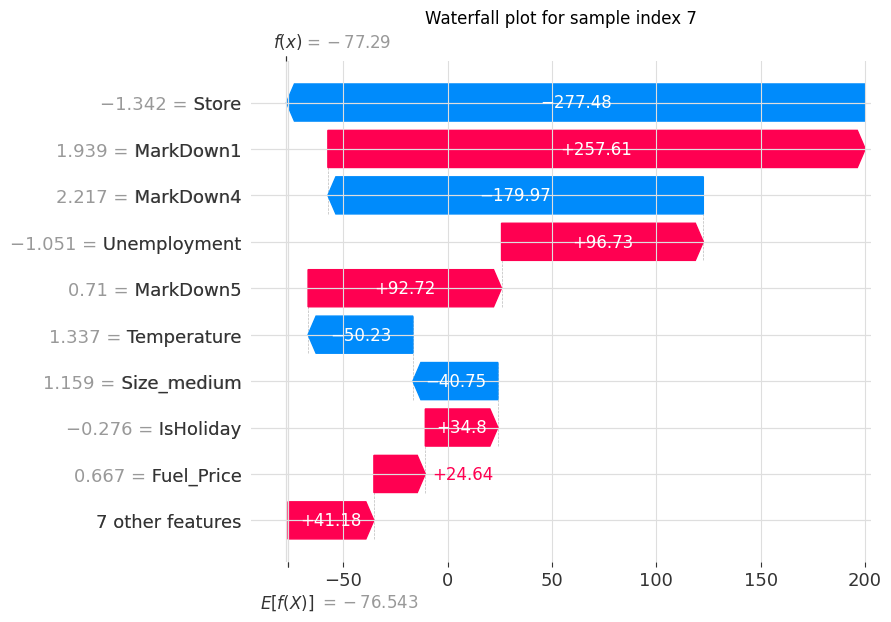

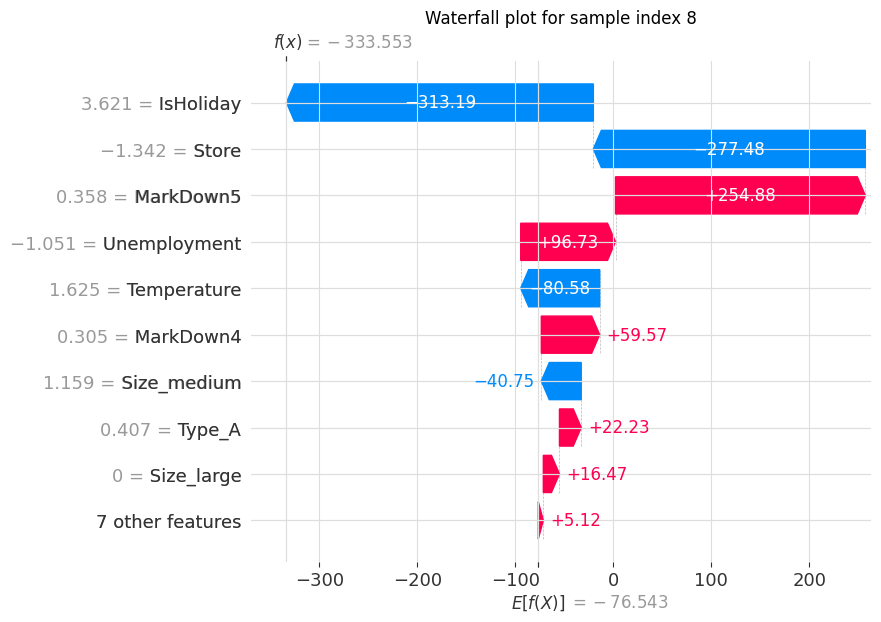

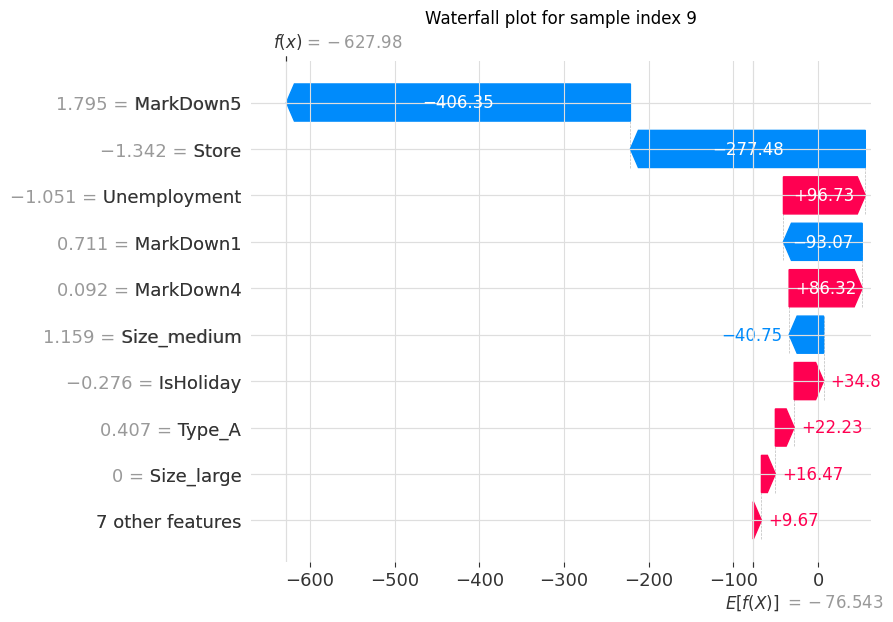

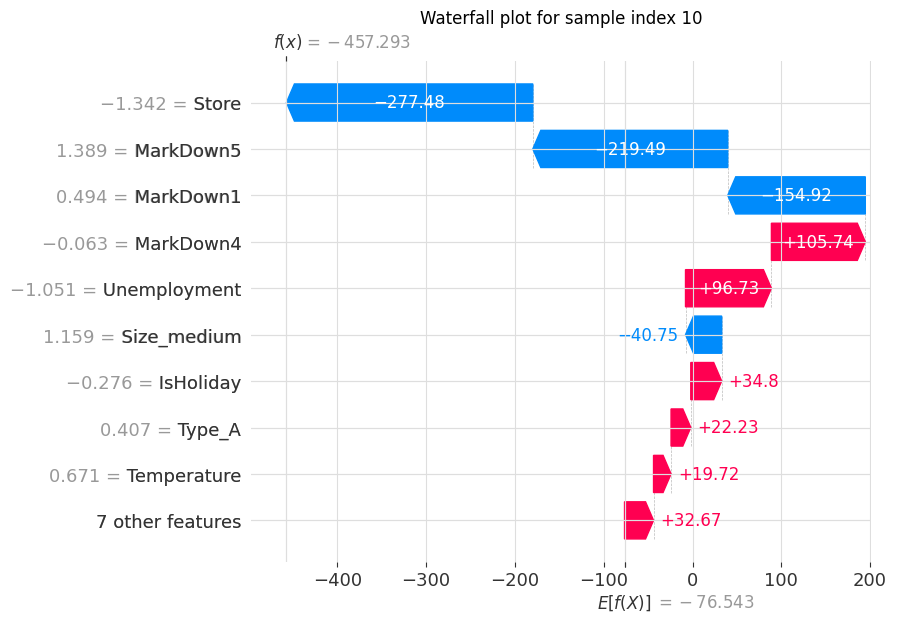

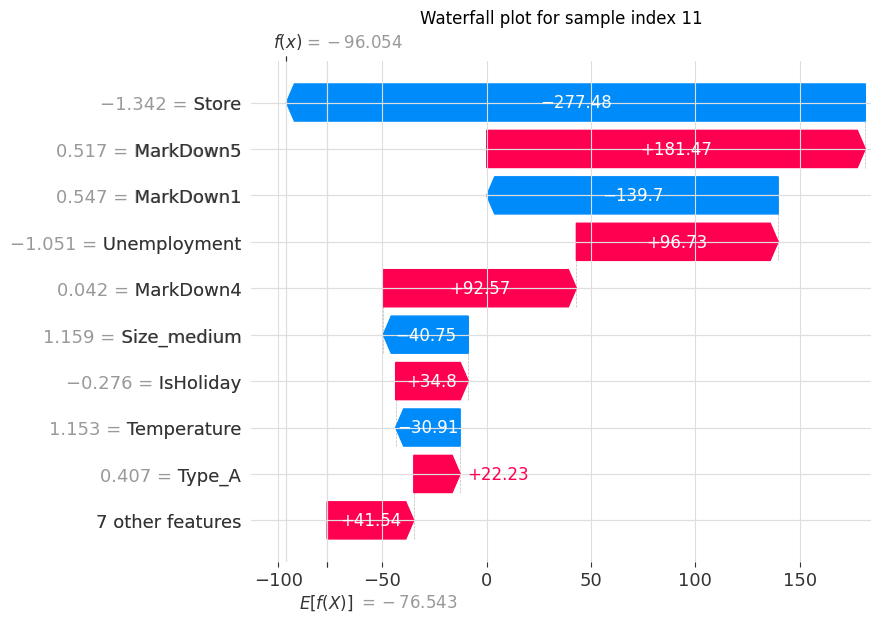

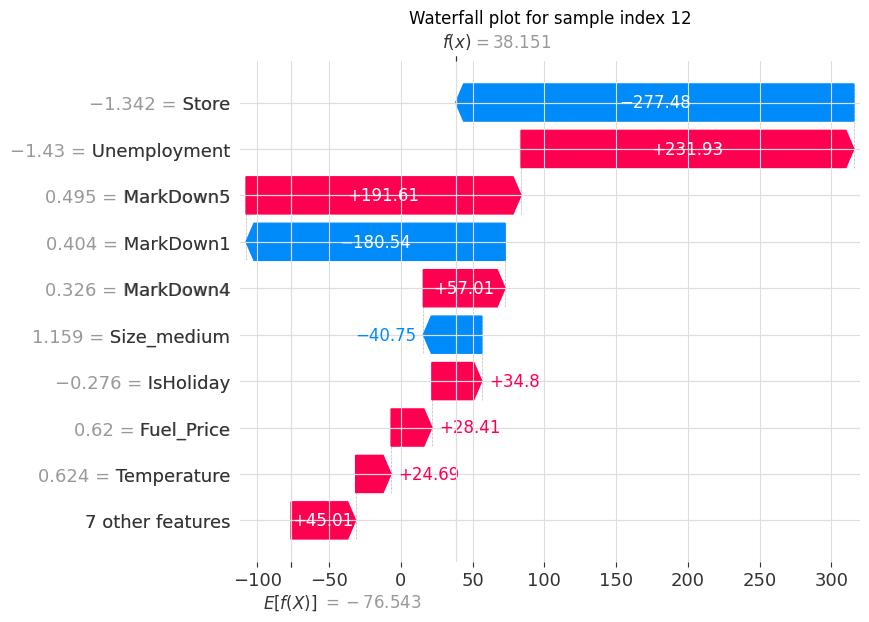

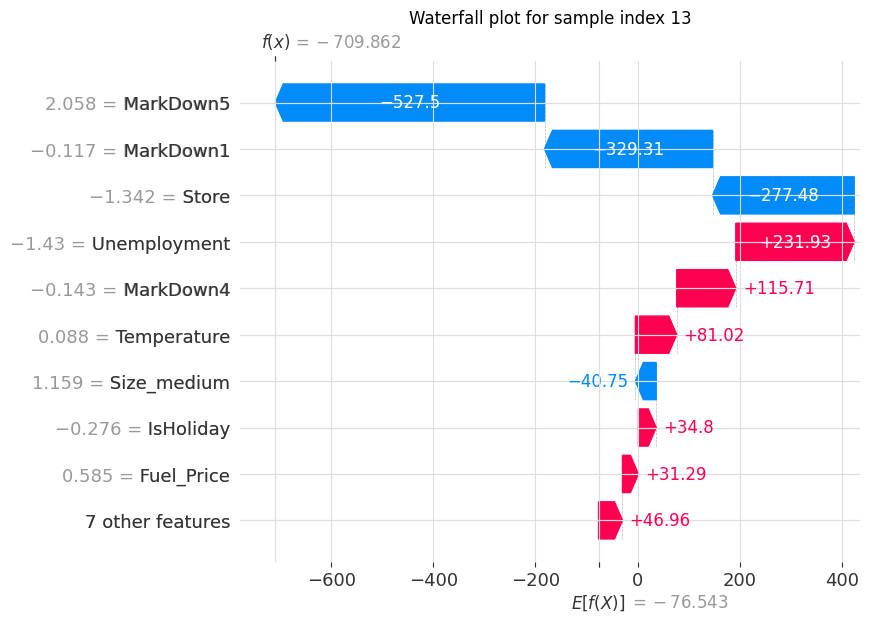

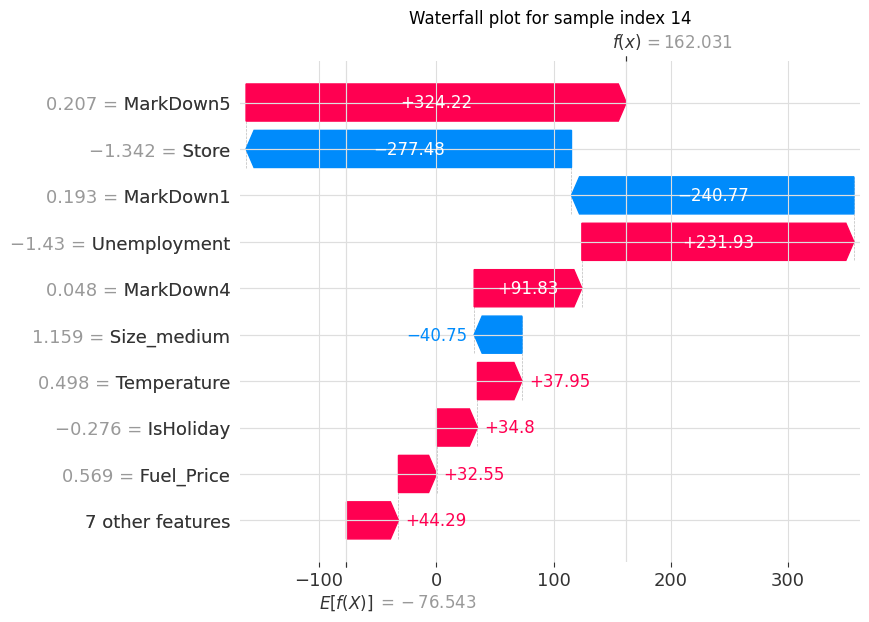

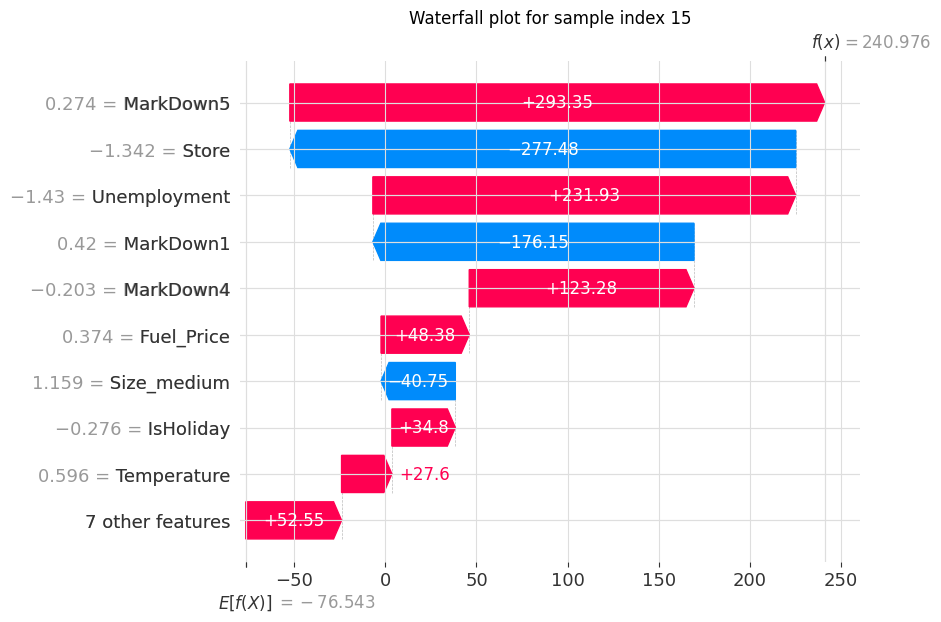

In [153]:
# expected_value = explainer.expected_value
# if isinstance(expected_value, np.ndarray):
#     expected_value = expected_value[0] 

# explanation = shap.Explanation(
#     values=shap_values,
#     base_values=expected_value,  # Valor(es) de base do modelo
#     data=X_test_id.values,          # Dados de entrada
#     feature_names=X_test_id.columns # Nomes das características
# )



for i in range(len(X_filtered)):
    plt.figure()
    shap.plots.waterfall(shap_values_filtered[i], max_display=10, show=False)
    plt.title(f"Waterfall plot for sample index {i}")
    plt.show()


In [154]:
df_analise=pd.DataFrame()
df_analise['final_forecast_catboost']=forecast_final_catboost
df_analise['final_forecast_tree']=forecast_final_tree
df_analise['final_forecast_lr']=forecast_final_lr
df_analise['forecast_prophet']=df_test['yhat']
df_analise['residuals_catboost']=y_pred_catboost
df_analise['residuals_tree']=y_pred_tree
df_analise['residuals_lr']=y_pred
df_analise['actual_value']=df_test['y']
df_analise

final_forecast_catboost  final_forecast_tree  final_forecast_lr  \
0                26059.616461         40654.087764       24245.202161   
1                29145.134868         41354.245215       24066.383178   
2                27306.779799         25701.489272       24305.524191   
3                22550.836648         24950.690827       24573.106286   
4                31592.198374         25064.198005       22816.756123   
...                       ...                  ...                ...   
7531             13658.640296         14202.819389       14503.738766   
7532             16062.481274         32432.029054       15982.559967   
7533             16124.544122         16455.399283       17346.916489   
7534             17118.576328         16891.775178       17765.233482   
7535             16363.199797          9675.599853       17199.342006   

      forecast_prophet  residuals_catboost  residuals_tree  residuals_lr  \
0         23893.739745         2165.876716    16760.348019    351.462416   
1         24593.897196         4551.237673    16760.348019   -527.514018   
2         24214.501573         3092.278226     1486.987699     91.022618   
3         23463.703129         -912.866481     1486.987699   1109.403157   
4         23577.210307         8014.988067     1486.987699   -760.454183   
...                ...                 ...             ...           ...   
7531      14613.199054         -954.558758     -410.379665   -109.460289   
7532      15649.794411          412.686863    16782.234643    332.765556   
7533      16865.778948         -741.234826     -410.379665    481.137541   
7534      17302.154843         -183.578515     -410.379665    463.078638   
7535      17016.368749         -653.168952    -7340.768896    182.973256   

      actual_value  
0         26000.97  
1         27065.94  
2         26303.34  
3         26390.26  
4         26320.29  
...            ...  
7531      16293.63  
7532      16475.72  
7533      17300.73  
7534      17641.28  
7535      19176.14  

[7536 rows x 8 columns]

In [155]:
tree_rmse=mean_squared_error(df_analise['actual_value'],df_analise['final_forecast_tree'],squared=False)
print('RMSE on final forecast test set tree:',tree_rmse)
catboost_rmse=mean_squared_error(df_analise['actual_value'],df_analise['final_forecast_catboost'],squared=False)
print('RMSE on final forecast test set catboost',catboost_rmse)
lr_rmse=mean_squared_error(df_analise['actual_value'],df_analise['final_forecast_lr'],squared=False)
print('RMSE on final forecast test set lr:',lr_rmse)

RMSE on final forecast test set tree: 5406.294352514317
RMSE on final forecast test set catboost 5225.022181312657
RMSE on final forecast test set lr: 4915.485175077223


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
